In [1]:
from __future__ import print_function

import mixed_models

import os
import sys
sys.path.insert(0, os.path.abspath("../.."))

import numpy
import pandas
import geopandas
from shapely import wkb, wkt

from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import pytz

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText

/home/ipython/software/python/python27/virtualenvs/pairs-python/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Matrix

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [2]:
# For Both Cases and Growth we use the same ROLLING_WINDOW 
ROLLING_WINDOW = 14
lag_growthCases = 19
lag_growthCasesStd = 4 

lag_Feature = numpy.arange(lag_growthCases-lag_growthCasesStd, lag_growthCases+lag_growthCasesStd+1, 1)
print('lag_Feature', lag_Feature)

dt_cutoff_training_COVID = datetime(2020,5,31, tzinfo=pytz.utc)
#dt_cutoff_training_COVID = datetime(2020,7,25, tzinfo=pytz.utc)
print('Training only with COVID growth data until ', dt_cutoff_training_COVID)
dt_cutoff_training_mobility = dt_cutoff_training_COVID - timedelta(days=lag_growthCases - lag_growthCasesStd)
print('Training only with Mobility data until     ', dt_cutoff_training_mobility)
dt_cutoff_min = datetime(2020, 3, 1, tzinfo=pytz.utc)
print('Considering data from                      ', dt_cutoff_min)
dt_cutoff_latest = datetime(2020,8,2, tzinfo=pytz.utc)
print('Plotting data up to                        ', dt_cutoff_latest)

data_subdirectory = 'data/csv/run98May31JHU'
if not os.path.exists(data_subdirectory):
    os.makedirs(data_subdirectory)
print('data_subdirectory                          ', data_subdirectory)

lag_Feature [15 16 17 18 19 20 21 22 23]
Training only with COVID growth data until  2020-05-31 00:00:00+00:00
Training only with Mobility data until      2020-05-16 00:00:00+00:00
Considering data from                       2020-03-01 00:00:00+00:00
Plotting data up to                         2020-08-02 00:00:00+00:00
data_subdirectory                           data/csv/run98May31JHU


In [3]:
# Get the region data (county ids, names, and polygons)
df_region = pandas.read_csv(os.path.join(data_subdirectory, 'df_region.csv'))
df_region['poly'] = df_region['poly'].apply(lambda x: wkb.loads(x, hex=True))
df_region = geopandas.GeoDataFrame(df_region, geometry='poly')

df_region.tail()

pairs_id              name    County    State  \
3136     53137  Wyoming.Niobrara  Niobrara  Wyoming   
3137     53138  Wyoming.Converse  Converse  Wyoming   
3138     53139    Wyoming.Goshen    Goshen  Wyoming   
3139     53140    Wyoming.Platte    Platte  Wyoming   
3140     53141   Wyoming.Laramie   Laramie  Wyoming   

                                                   poly  
3136  POLYGON ((-104.0591572933003 43.47913436795783...  
3137  POLYGON ((-104.900693294084 42.61192936715017,...  
3138  POLYGON ((-104.0535132932951 41.99981536658019...  
3139  POLYGON ((-104.6506362938513 41.65636536626036...  
3140  POLYGON ((-104.055500293297 41.56422236617438,...

In [4]:
# Get the population density data
df_pop_density = pandas.read_csv(os.path.join(data_subdirectory, 'df_pop_density.csv'))
df_pop_density.tail()

pairs_id  population_density
3135     53137            0.346710
3136     53138            1.254922
3137     53139            2.286790
3138     53140            1.519373
3139     53141           14.217309

In [5]:
# Read from disk
df_AgeRatio = pandas.read_csv(os.path.join(data_subdirectory, 'df_AgeRatio.csv'))

df_AgeRatio.tail()

pairs_id  AgeRatio  LogAgeRatio
3135     53137  1.466165     0.166183
3136     53138  1.474648     0.168688
3137     53139  1.263804     0.101680
3138     53140  1.867769     0.271323
3139     53141  0.951245    -0.021707

In [6]:
"""
# Get the population data
df_population = pandas.read_csv(os.path.join(data_subdirectory, 'df_population.csv'))
df_population.tail()

# Get processed GrowthCases DataFrame
df_GrowthCases = pandas.read_csv(os.path.join(data_subdirectory, 'df_GrowthCases.csv'), index_col='timestamp')
df_GrowthCases.index = pandas.to_datetime(df_GrowthCases.index)
df_GrowthCases.columns = df_GrowthCases.columns.astype(int)
df_GrowthCases.columns.name = 'pairs_id'
df_GrowthCases.tail()

# Get processed CasesCapita DataFrame
df_CasesCapita = pandas.read_csv(os.path.join(data_subdirectory, 'df_CasesCapita.csv'), index_col='timestamp')
df_CasesCapita.index = pandas.to_datetime(df_CasesCapita.index)
df_CasesCapita.columns = df_CasesCapita.columns.astype(int)
df_CasesCapita.columns.name = 'pairs_id'
df_CasesCapita.tail()

# Get processed LogMobility DataFrame
df_LogMobility = pandas.read_csv(os.path.join(data_subdirectory, 'df_LogMobility.csv'), index_col='timestamp')
df_LogMobility.index = pandas.to_datetime(df_LogMobility.index)
df_LogMobility.columns = df_LogMobility.columns.astype(int)
df_LogMobility.columns.name = 'pairs_id'
df_LogMobility.tail()

# Get processed Diffusion DataFrame
df_Diffusion = pandas.read_csv(os.path.join(data_subdirectory, 'df_Diffusion.csv'), index_col='timestamp')
df_Diffusion.index = pandas.to_datetime(df_Diffusion.index)
df_Diffusion.columns = df_Diffusion.columns.astype(int)
df_Diffusion.columns.name = 'pairs_id'
df_Diffusion.tail()
"""

"\n# Get the population data\ndf_population = pandas.read_csv(os.path.join(data_subdirectory, 'df_population.csv'))\ndf_population.tail()\n\n# Get processed GrowthCases DataFrame\ndf_GrowthCases = pandas.read_csv(os.path.join(data_subdirectory, 'df_GrowthCases.csv'), index_col='timestamp')\ndf_GrowthCases.index = pandas.to_datetime(df_GrowthCases.index)\ndf_GrowthCases.columns = df_GrowthCases.columns.astype(int)\ndf_GrowthCases.columns.name = 'pairs_id'\ndf_GrowthCases.tail()\n\n# Get processed CasesCapita DataFrame\ndf_CasesCapita = pandas.read_csv(os.path.join(data_subdirectory, 'df_CasesCapita.csv'), index_col='timestamp')\ndf_CasesCapita.index = pandas.to_datetime(df_CasesCapita.index)\ndf_CasesCapita.columns = df_CasesCapita.columns.astype(int)\ndf_CasesCapita.columns.name = 'pairs_id'\ndf_CasesCapita.tail()\n\n# Get processed LogMobility DataFrame\ndf_LogMobility = pandas.read_csv(os.path.join(data_subdirectory, 'df_LogMobility.csv'), index_col='timestamp')\ndf_LogMobility.index

In [7]:
# Get processed LogCases DataFrame
df_LogCases = pandas.read_csv(os.path.join(data_subdirectory, 'df_LogCases.csv'), index_col='timestamp')
df_LogCases.index = pandas.to_datetime(df_LogCases.index)
df_LogCases.columns = df_LogCases.columns.astype(int)
df_LogCases.columns.name = 'pairs_id'
df_LogCases.tail()

pairs_id                   50001     50002     50003     50004     50005  \
timestamp                                                                  
2020-07-29 00:00:00+00:00    NaN  3.266246  4.681551  3.272141  1.863092   
2020-07-30 00:00:00+00:00    NaN  3.300205  4.737235  3.313378  1.973123   
2020-07-31 00:00:00+00:00    NaN  3.279043  4.663117  3.335341  1.990349   
2020-08-01 00:00:00+00:00    NaN  3.200571  4.620969  3.244733  1.994397   
2020-08-02 00:00:00+00:00    NaN  3.195643  4.607430  3.244733  2.142928   

pairs_id                      50006     50007     50008     50009     50010  \
timestamp                                                                     
2020-07-29 00:00:00+00:00  3.600510  2.364528  2.263144  1.528152  2.580163   
2020-07-30 00:00:00+00:00  3.665428  2.443001  2.287177  1.504118  2.577304   
2020-07-31 00:00:00+00:00  3.617079  2.447083  2.256407  1.528152  2.587906   
2020-08-01 00:00:00+00:00  3.580591  2.462037  2.144363  1.548701  2.711806   
2020-08-02 00:00:00+00:00  3.593045  2.515410  2.126412  1.548701  2.768124   

pairs_id                   ...     53132     53133     53134     53135  \
timestamp                  ...                                           
2020-07-29 00:00:00+00:00  ...  0.449398  0.779226  0.520930  0.666531   
2020-07-30 00:00:00+00:00  ...  0.391474  0.878247  0.619951  0.745003   
2020-07-31 00:00:00+00:00  ...  0.480957  0.878247  0.718972  0.745003   
2020-08-01 00:00:00+00:00  ...  0.546407  0.878247  0.797444  0.666531   
2020-08-02 00:00:00+00:00  ...  0.674389  0.878247  0.858786  0.602539   

pairs_id                      53136  53137     53138     53139     53140  \
timestamp                                                                  
2020-07-29 00:00:00+00:00  1.700903    NaN -2.071996 -1.922198 -3.044522   
2020-07-30 00:00:00+00:00  1.779375    NaN -2.121507 -1.922198 -3.044522   
2020-07-31 00:00:00+00:00  1.758826    NaN -2.171017 -1.922198 -3.044522   
2020-08-01 00:00:00+00:00  1.651392    NaN -2.249490 -1.849941 -3.044522   
2020-08-02 00:00:00+00:00  1.613614    NaN -2.327962 -1.777683 -3.044522   

pairs_id                      53141  
timestamp                            
2020-07-29 00:00:00+00:00  1.761523  
2020-07-30 00:00:00+00:00  1.851006  
2020-07-31 00:00:00+00:00  1.841468  
2020-08-01 00:00:00+00:00  1.854491  
2020-08-02 00:00:00+00:00  1.886055  

[5 rows x 3136 columns]

In [8]:
# Get processed Mobility DataFrame
df_Mobility = pandas.read_csv(os.path.join(data_subdirectory, 'df_Mobility.csv'), index_col='timestamp')
df_Mobility.index = pandas.to_datetime(df_Mobility.index)
df_Mobility.columns = df_Mobility.columns.astype(int)
df_Mobility.columns.name = 'pairs_id'
df_Mobility.tail()

pairs_id                      50001      50002     50003     50004      50005  \
timestamp                                                                       
2020-07-29 00:00:00+00:00  8.874857  10.466500  7.389429  7.701857  14.377643   
2020-07-30 00:00:00+00:00  8.841857  10.357143  7.313143  7.705500  14.482286   
2020-07-31 00:00:00+00:00  8.788071  10.405357  7.236071  7.711143  14.571500   
2020-08-01 00:00:00+00:00  8.773714  10.348571  7.204714  7.683143  14.604857   
2020-08-02 00:00:00+00:00  8.720500  10.299571  7.151643  7.718143  14.677714   

pairs_id                      50006      50007      50008      50009  \
timestamp                                                              
2020-07-29 00:00:00+00:00  8.945214  10.908143  11.178786  10.404857   
2020-07-30 00:00:00+00:00  8.899286  10.864929  11.097286  10.193214   
2020-07-31 00:00:00+00:00  8.739286  11.043286  11.187500  10.159000   
2020-08-01 00:00:00+00:00  8.705643  11.101000  11.269357  10.078357   
2020-08-02 00:00:00+00:00  8.704143  11.017357  11.192357  10.200357   

pairs_id                      50010  ...     53132     53133      53134  \
timestamp                            ...                                  
2020-07-29 00:00:00+00:00  9.866929  ...  9.709929  4.135357  57.702357   
2020-07-30 00:00:00+00:00  9.863214  ...  9.604357  4.121857  57.437571   
2020-07-31 00:00:00+00:00  9.875286  ...  9.637643  4.136357  58.462429   
2020-08-01 00:00:00+00:00  9.747071  ...  9.452214  4.124500  56.027500   
2020-08-02 00:00:00+00:00  9.653000  ...  9.158929  4.060143  55.206000   

pairs_id                      53135     53136  53137     53138     53139  \
timestamp                                                                  
2020-07-29 00:00:00+00:00  3.952214  4.511000    NaN  5.277500  2.709357   
2020-07-30 00:00:00+00:00  3.930643  4.487286    NaN  5.183929  2.617429   
2020-07-31 00:00:00+00:00  4.010429  4.500286    NaN  5.370500  2.443357   
2020-08-01 00:00:00+00:00  4.080357  4.476429    NaN  4.743786  2.363071   
2020-08-02 00:00:00+00:00  4.094429  4.394571    NaN  4.664929  2.315000   

pairs_id                      53140     53141  
timestamp                                      
2020-07-29 00:00:00+00:00  6.745929  4.533429  
2020-07-30 00:00:00+00:00  6.824571  4.525857  
2020-07-31 00:00:00+00:00  6.890286  4.534786  
2020-08-01 00:00:00+00:00  6.844000  4.529071  
2020-08-02 00:00:00+00:00  6.555857  4.467929  

[5 rows x 3136 columns]

In [9]:
# Get processed and joined DataFrame
df_joined = pandas.read_csv(os.path.join(data_subdirectory, 'df_joined.csv'), header=[0,1], index_col=0)
df_joined.index = pandas.to_datetime(df_joined.index)
# Change type of pairs_id in multiindex column to integer by transposing twice
df_joined = df_joined.T.reset_index()
df_joined['pairs_id'] = df_joined['pairs_id'].astype(int)
df_joined = df_joined.set_index(['level_0', 'pairs_id']).T
df_joined.columns.names = [None, 'pairs_id']
# Need to make it datetime index again  dtype='datetime64[ns, UTC]'
df_joined.index = df_joined.reset_index()['timestamp']
df_joined

Mobility                                  \
pairs_id                      50001      50002      50003     50004   
timestamp                                                             
2020-03-01 00:00:00+00:00  7.224000   9.717000   7.623000  7.120000   
2020-03-02 00:00:00+00:00  8.231000  12.095000   8.757500  7.632000   
2020-03-03 00:00:00+00:00  8.759000  12.958333   9.251667  8.020667   
2020-03-04 00:00:00+00:00  9.037750  13.501500   9.522500  8.125750   
2020-03-05 00:00:00+00:00  9.338000  13.985200   9.793600  8.313200   
2020-03-06 00:00:00+00:00  9.692000  14.616167  10.073500  8.703833   
2020-03-07 00:00:00+00:00  9.717714  14.519857  10.020000  8.956000   
2020-03-08 00:00:00+00:00  9.472125  13.995125   9.738250  8.766500   
2020-03-09 00:00:00+00:00  9.503333  14.064889   9.796444  8.741778   
2020-03-10 00:00:00+00:00  9.492200  14.111900   9.845300  8.757000   
2020-03-11 00:00:00+00:00  9.502182  14.132545   9.898091  8.743636   
2020-03-12 00:00:00+00:00  9.594000  14.236917   9.965167  8.774750   
2020-03-13 00:00:00+00:00  9.674385  14.362462  10.035692  8.850462   
2020-03-14 00:00:00+00:00  9.568571  14.134429   9.873714  8.821714   
2020-03-15 00:00:00+00:00  9.492500  13.885286   9.658857  8.738643   
2020-03-16 00:00:00+00:00  9.509786  13.682071   9.545500  8.684429   
2020-03-17 00:00:00+00:00  9.362786  13.311286   9.300929  8.552071   
2020-03-18 00:00:00+00:00  9.205286  12.843357   8.999929  8.442714   
2020-03-19 00:00:00+00:00  9.021571  12.323714   8.658071  8.284786   
2020-03-20 00:00:00+00:00  8.723071  11.714786   8.260857  8.013929   
2020-03-21 00:00:00+00:00  8.412071  11.144429   7.789571  7.607714   
2020-03-22 00:00:00+00:00  8.100214  10.691357   7.349929  7.285286   
2020-03-23 00:00:00+00:00  7.810643  10.052429   6.874429  7.019786   
2020-03-24 00:00:00+00:00  7.472500   9.380429   6.324071  6.687286   
2020-03-25 00:00:00+00:00  7.290143   8.909786   5.906286  6.466357   
2020-03-26 00:00:00+00:00  7.031286   8.345286   5.475000  6.235000   
2020-03-27 00:00:00+00:00  6.800786   7.848857   5.093643  6.001071   
2020-03-28 00:00:00+00:00  6.598000   7.473643   4.775143  5.720000   
2020-03-29 00:00:00+00:00  6.421429   7.291500   4.520786  5.516000   
2020-03-30 00:00:00+00:00  6.135429   6.878500   4.148286  5.351857   
...                             ...        ...        ...       ...   
2020-07-04 00:00:00+00:00  9.122643  11.029214   7.743143  8.363000   
2020-07-05 00:00:00+00:00  9.086857  10.853143   7.664714  8.305286   
2020-07-06 00:00:00+00:00  9.172929  10.871929   7.746643  8.431929   
2020-07-07 00:00:00+00:00  9.220429  10.912357   7.762214  8.476929   
2020-07-08 00:00:00+00:00  9.320786  11.006071   7.854286  8.617429   
2020-07-09 00:00:00+00:00  9.320214  10.911857   7.805643  8.630214   
2020-07-10 00:00:00+00:00  9.351714  11.035357   7.818786  8.721357   
2020-07-11 00:00:00+00:00  9.351643  11.012143   7.825143  8.827429   
2020-07-12 00:00:00+00:00  9.265071  10.878786   7.703286  8.741429   
2020-07-13 00:00:00+00:00  9.370143  10.957857   7.765071  8.782071   
2020-07-14 00:00:00+00:00  9.426500  11.038071   7.808643  8.753000   
2020-07-15 00:00:00+00:00  9.459500  11.064643   7.835643  8.709071   
2020-07-16 00:00:00+00:00  9.423286  11.031714   7.793357  8.623929   
2020-07-17 00:00:00+00:00  9.488714  11.025643   7.851429  8.558071   
2020-07-18 00:00:00+00:00  9.555571  11.189714   7.941857  8.551286   
2020-07-19 00:00:00+00:00  9.535143  11.226571   7.963214  8.424929   
2020-07-20 00:00:00+00:00  9.469857  11.213786   7.898143  8.345571   
2020-07-21 00:00:00+00:00  9.408643  11.122571   7.832643  8.263286   
2020-07-22 00:00:00+00:00  9.319143  10.987786   7.761286  8.139071   
2020-07-23 00:00:00+00:00  9.246571  10.925143   7.695286  8.009000   
2020-07-24 00:00:00+00:00  9.186286  10.829500   7.651214  7.882500   
2020-07-25 00:00:00+00:00  9.092929  10.643429   7.583857  7.735786   
2020-07-26 00:00:00+00:00  9.129643  10.716143   7.

In [10]:
def lagged_dataframe(df_joined, lag_growthCases):
    df1 = df_joined['GrowthCases'].shift(periods=-lag_growthCases)
    df1.columns = pandas.MultiIndex.from_product([['subsequent_GrowthCases'], df1.columns])
    df1.columns.names = [None, 'pairs_id']

    df_lagged = pandas.merge(df_joined[['Mobility']], 
                             df_joined[['LogMobility']], left_index=True, right_index=True)
    df_lagged = pandas.merge(df_lagged,
                             df_joined[['CasesCapita']], left_index=True, right_index=True)
    df_lagged = pandas.merge(df_lagged, df1, left_index=True, right_index=True)
    return df_lagged

def filter_lagged_dataframe(df_unfiltered, 
                            filter_cases_capita_min, 
                            filter_growth_cases_zero_transition,
                            filter_logMobility_min):
    """
    :df_unfiltered: lagged dataframe (e.g. df_lagged)
    :returns:       filtered dataframe
    """
    df = df_unfiltered.copy()
    
    if filter_cases_capita_min is not None:
        df = df[df['CasesCapita']>=filter_cases_capita_min] 

    # Note we use 1e-10  and -1e-10 instead of 0 to avoid false positives due to floating point rounding errors
    if filter_growth_cases_zero_transition is not None:
        df_negative_transition = ((df_unfiltered['subsequent_GrowthCases']<-1e-10) & 
                                  (df_unfiltered['subsequent_GrowthCases'].shift()>1e-10))
        df_positive_transition = ((df_unfiltered['subsequent_GrowthCases']>1e-10) & 
                                  (df_unfiltered['subsequent_GrowthCases'].shift()<-1e-10))
        df_zero_transition = (df_negative_transition | df_positive_transition)
        df = df[df_zero_transition]

    if filter_logMobility_min is not None:
        df = df[df['LogMobility']>=filter_logMobility_min] # S/N
        
    return df

In [11]:
# Lagged and Filtered DataFrame
# ONLY THE GrowthCases IS SHIFTED

# Filter on the lagged data, not on df_joined
FILTER_CASES_CAPITA_MIN = 2
FILTER_GROWTH_CASES_ZERO_TRANSITION = True
FILTER_LOGMOBILITY_MIN = -2

df_lagged = {}
df_lagged_filtered = {}

for this_lag in lag_Feature:
    df_lagged[this_lag] = lagged_dataframe(df_joined, this_lag)

    df_lagged_filtered[this_lag] = filter_lagged_dataframe(df_lagged[this_lag], 
                                                         FILTER_CASES_CAPITA_MIN,
                                                         FILTER_GROWTH_CASES_ZERO_TRANSITION,
                                                         FILTER_LOGMOBILITY_MIN)

    df_lagged[this_lag] = df_lagged[this_lag].swaplevel(axis=1)
    df_lagged_filtered[this_lag] = df_lagged_filtered[this_lag].swaplevel(axis=1)
    
df_lagged_filtered[lag_growthCases]

pairs_id                     50001    50002     50003    50004    50005  \
                          Mobility Mobility  Mobility Mobility Mobility   
timestamp                                                                 
2020-03-01 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-02 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-03 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-04 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-05 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-06 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-07 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-08 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-09 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-10 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-11 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-12 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-13 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-14 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-15 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-16 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-17 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-18 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-19 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-20 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-21 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-22 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-23 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-24 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-25 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-26 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-27 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-28 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-29 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-03-30 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
...                            ...      ...       ...      ...      ...   
2020-07-04 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-05 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-06 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-07 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-08 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-09 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-10 00:00:00+00:00      NaN      NaN  7.818786      NaN      NaN   
2020-07-11 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-12 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-13 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-14 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-15 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-16 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-17 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-18 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-19 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-20 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-21 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-22 00:00:00+00:00      NaN      NaN       NaN      NaN      NaN   
2020-07-23 00:00:00+00:00

In [12]:
df_critical = pandas.DataFrame()

# Critical mobility
for this_lag in lag_Feature:
    df = df_lagged_filtered[this_lag].swaplevel(axis=1)[['LogMobility']].stack(
        dropna=False).reset_index().rename(columns={'LogMobility': 'LogCriticalMobility'})
    df['lag'] = this_lag
    df_critical = pandas.concat([df_critical, df])
df_critical = df_critical.reset_index(drop=True)

# List of timestamps
dt_list = pandas.date_range(start=df_critical['timestamp'].min(), end=df_critical['timestamp'].max())

# Population density
df_repeated = pandas.concat([df_pop_density.set_index('pairs_id')]*len(dt_list), axis=1)
df_repeated.columns = dt_list
df_repeated = df_repeated.stack().reset_index().rename(columns={'level_1':'timestamp', 0:'population_density'})
df_critical = pandas.merge(df_critical, df_repeated, on=['timestamp', 'pairs_id'], how='outer')
df_critical['LogPopDensity'] = numpy.log10(df_critical['population_density'])

# LogAgeRatio (log10(age60-64 / age20-24))
df_repeated = pandas.concat([df_AgeRatio[['pairs_id', 'LogAgeRatio']].set_index('pairs_id')]*len(dt_list), axis=1)
df_repeated.columns = dt_list
df_repeated = df_repeated.stack().reset_index().rename(columns={'level_1':'timestamp', 0:'LogAgeRatio'})
df_critical = pandas.merge(df_critical, df_repeated, on=['timestamp', 'pairs_id'], how='outer')

# Diffusion
df_stacked = df_joined['Diffusion'].stack(dropna=False).reset_index().rename(columns={0: 'Diffusion'})
df_critical = pandas.merge(df_critical, df_stacked, on=['timestamp', 'pairs_id'], how='outer')

# LogCases
df_stacked = df_joined['LogCases'].stack(dropna=False).reset_index().rename(columns={0: 'LogCases'})
df_critical = pandas.merge(df_critical, df_stacked, on=['timestamp', 'pairs_id'], how='outer')
df_critical['Cases'] = numpy.exp(df_critical['LogCases'])

# GrowthCases
df_stacked = df_joined['GrowthCases'].stack(dropna=False).reset_index().rename(columns={0: 'GrowthCases'})
df_critical = pandas.merge(df_critical, df_stacked, on=['timestamp', 'pairs_id'], how='outer')

# CasesCapita and LogCasesCapita
df_stacked = df_joined['CasesCapita'].stack(dropna=False).reset_index().rename(columns={0: 'CasesCapita'})
df_critical = pandas.merge(df_critical, df_stacked, on=['timestamp', 'pairs_id'], how='outer')
df_critical['LogCasesCapita'] = numpy.log10(df_critical['CasesCapita'])

# CumCasesCapita and LogCumCasesCapita
df_stacked = df_joined['CumCasesCapita'].stack(dropna=False).reset_index().rename(columns={0: 'CumCasesCapita'})
df_critical = pandas.merge(df_critical, df_stacked, on=['timestamp', 'pairs_id'], how='outer')
df_critical['LogCumCasesCapita'] = numpy.log10(df_critical['CumCasesCapita'])

# LogMobility
df_stacked = df_joined['LogMobility'].stack(dropna=False).reset_index().rename(columns={0: 'LogMobility'})
df_critical = pandas.merge(df_critical, df_stacked, on=['timestamp', 'pairs_id'], how='outer')

# Mobility
df_stacked = df_joined['Mobility'].stack(dropna=False).reset_index().rename(columns={0: 'Mobility'})
df_critical = pandas.merge(df_critical, df_stacked, on=['timestamp', 'pairs_id'], how='outer')

# MaxMobility
df_stacked = df_joined['MaxMobility'].stack(dropna=False).reset_index().rename(columns={0: 'MaxMobility'})
df_critical = pandas.merge(df_critical, df_stacked, on=['timestamp', 'pairs_id'], how='outer')
df_critical['LogMaxMobility'] = numpy.log10(df_critical['MaxMobility'])

# State and County names
df_critical = pandas.merge(df_region[['State', 'County', 'pairs_id']], df_critical, on='pairs_id', how='right')

# In order to use the date as random effect
df_critical['date'] = df_critical['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))

# Don't use timestamps with too little data for the fit
df_critical = df_critical[df_critical['timestamp']>=datetime(2020,3,25, tzinfo=pytz.utc)].reset_index(drop=True)

df_critical['day'] = df_critical['timestamp'].apply(lambda x: (x-datetime(2020,1,1, tzinfo=pytz.utc)).days)

def days2timedelta(lag):
    """
    helper function much faster than datetime timedelta
    """
    microseconds = numpy.around(numpy.asarray(lag) * (24*60*60*10**6))
    return microseconds.astype('timedelta64[us]')

df_critical['timestamp_covid_training'] = df_critical['timestamp'] + days2timedelta(df_critical['lag'])

df_critical.tail().T

3697863  \
State                                       Wyoming   
County                                      Laramie   
pairs_id                                      53141   
timestamp                 2020-08-02 00:00:00+00:00   
LogCriticalMobility                             NaN   
lag                                              19   
population_density                          14.2173   
LogPopDensity                               1.15282   
LogAgeRatio                              -0.0217075   
Diffusion                                   4.26004   
LogCases                                    1.88605   
Cases                                        6.5933   
GrowthCases                               0.0101627   
CasesCapita                                 6.62644   
LogCasesCapita                              0.82128   
CumCasesCapita                              386.691   
LogCumCasesCapita                           2.58736   
LogMobility                                0.650106   
Mobility                                    4.46793   
MaxMobility                                 4.53785   
LogMaxMobility                              0.65685   
date                                     2020-08-02   
day                                             214   
timestamp_covid_training  2020-08-21 00:00:00+00:00   

                                            3697864  \
State                                       Wyoming   
County                                      Laramie   
pairs_id                                      53141   
timestamp                 2020-08-02 00:00:00+00:00   
LogCriticalMobility                             NaN   
lag                                              20   
population_density                          14.2173   
LogPopDensity                               1.15282   
LogAgeRatio                              -0.0217075   
Diffusion                                   4.26004   
LogCases                                    1.88605   
Cases                                        6.5933   
GrowthCases                               0.0101627   
CasesCapita                                 6.62644   
LogCasesCapita                              0.82128   
CumCasesCapita                              386.691   
LogCumCasesCapita                           2.58736   
LogMobility                                0.650106   
Mobility                                    4.46793   
MaxMobility                                 4.53785   
LogMaxMobility                              0.65685   
date                                     2020-08-02   
day                                             214   
timestamp_covid_training  2020-08-22 00:00:00+00:00   

                                            3697865  \
State                                       Wyoming   
County                                      Laramie   
pairs_id                                      53141   
timestamp                 2020-08-02 00:00:00+00:00   
LogCriticalMobility                             NaN   
lag                                              21   
population_density                          14.2173   
LogPopDensity                               1.15282   
LogAgeRatio                              -0.0217075   
Diffusion                                   4.26004   
LogCases                                    1.88605   
Cases                                        6.5933   
GrowthCases                               0.0101627   
CasesCapita                                 6.62644   
LogCasesCapita                              0.82128   
CumCasesCapita                              386.691   
LogCumCasesCapita                           2.58736   
LogMobility                                0.650106   
Mobility                                    4.46793   
MaxMobility                                 4.53785   
LogMaxMobility                              0.65685   
date                                     2020-08-02   
day                        

In [13]:
# Model parameter definition
model_params = {}
model_params['fe_features'] = ['LogPopDensity', 'Diffusion', 'LogCases', 'CumCasesCapita', 'LogAgeRatio', 'day']
model_params['fe_features_for_re_slopes'] = []
model_params['re_features'] = ['date']
model_params['re_terms'] = ['(1|date)']
for fixed_effect in model_params['fe_features_for_re_slopes']:
    model_params['re_terms'].append('(0+'+fixed_effect+'|date)')
model_params

{'fe_features': ['LogPopDensity',
  'Diffusion',
  'LogCases',
  'CumCasesCapita',
  'LogAgeRatio',
  'day'],
 'fe_features_for_re_slopes': [],
 're_features': ['date'],
 're_terms': ['(1|date)']}

In [14]:
# Training - Testing

# Mixed Model to fit population - critical mobility relationship with state random effects
verbose = True

target = 'LogCriticalMobility'

# Dataprep for lmer
training_set = df_critical.copy()
# Only use rows where LogCriticalMobility has been sampled
training_set = training_set.dropna(subset=['LogCriticalMobility']).reset_index(drop=True)
# Mobility timestamp training cutoff
training_set = training_set[training_set['timestamp']<=dt_cutoff_training_mobility].reset_index(drop=True)
# Covid timestamp training cutoff
training_set = training_set[training_set['timestamp_covid_training']<=dt_cutoff_training_COVID].reset_index(drop=True)
# Dummy variable for using mixed_models.py (we are not using 'year' feature)
training_set['year'] = 'dummy'

#print('Training only with COVID growth data until ', dt_cutoff_training_COVID)
print('Training only with COVID growth data until ', training_set['timestamp_covid_training'].max())
#print('Training only with mobility data until     ', dt_cutoff_training_mobility)
print('Training only with mobility data until     ', training_set['timestamp'].max())

del training_set['timestamp']
del training_set['timestamp_covid_training']

# For predicting we just need lag = lag_growthCases
prediction_set = df_critical[df_critical['lag']==lag_growthCases].reset_index(drop=True)
prediction_set['lag'] = numpy.nan
prediction_set['year'] = 'dummy'
s_timestamp = prediction_set['timestamp']
del prediction_set['timestamp']
del prediction_set['timestamp_covid_training']

prediction_set.tail()

Training only with COVID growth data until  2020-05-31 00:00:00+00:00
Training only with mobility data until      2020-05-16 00:00:00+00:00


State   County  pairs_id  LogCriticalMobility  lag  \
410811  Wyoming  Laramie     53141                  NaN  NaN   
410812  Wyoming  Laramie     53141                  NaN  NaN   
410813  Wyoming  Laramie     53141                  NaN  NaN   
410814  Wyoming  Laramie     53141                  NaN  NaN   
410815  Wyoming  Laramie     53141                  NaN  NaN   

        population_density  LogPopDensity  LogAgeRatio  Diffusion  LogCases  \
410811           14.217309       1.152817    -0.021707   4.551126  1.761523   
410812           14.217309       1.152817    -0.021707   4.334053  1.851006   
410813           14.217309       1.152817    -0.021707   4.364198  1.841468   
410814           14.217309       1.152817    -0.021707   4.339761  1.854491   
410815           14.217309       1.152817    -0.021707   4.260041  1.886055   

        ...  LogCasesCapita  CumCasesCapita  LogCumCasesCapita  LogMobility  \
410811  ...        0.767197      360.907901           2.557396     0.656427   
410812  ...        0.806059      367.306116           2.565028     0.655701   
410813  ...        0.801916      373.643594           2.572458     0.656557   
410814  ...        0.807572      380.064145           2.579857     0.656009   
410815  ...        0.821280      386.690581           2.587364     0.650106   

        Mobility  MaxMobility  LogMaxMobility        date  day   year  
410811  4.533429     4.537846         0.65685  2020-07-29  210  dummy  
410812  4.525857     4.537846         0.65685  2020-07-30  211  dummy  
410813  4.534786     4.537846         0.65685  2020-07-31  212  dummy  
410814  4.529071     4.537846         0.65685  2020-08-01  213  dummy  
410815  4.467929     4.537846         0.65685  2020-08-02  214  dummy  

[5 rows x 23 columns]

In [15]:
scaler = StandardScaler()
scaling_columns = model_params['fe_features']
training_set[scaling_columns] = scaler.fit_transform(training_set[scaling_columns])
prediction_set[scaling_columns] = scaler.transform(prediction_set[scaling_columns])

prediction_set.tail()

/home/ipython/software/python/python27/virtualenvs/pairs-python/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ipython/software/python/python27/virtualenvs/pairs-python/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ipython/software/python/python27/virtualenvs/pairs-python/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


State   County  pairs_id  LogCriticalMobility  lag  \
410811  Wyoming  Laramie     53141                  NaN  NaN   
410812  Wyoming  Laramie     53141                  NaN  NaN   
410813  Wyoming  Laramie     53141                  NaN  NaN   
410814  Wyoming  Laramie     53141                  NaN  NaN   
410815  Wyoming  Laramie     53141                  NaN  NaN   

        population_density  LogPopDensity  LogAgeRatio  Diffusion  LogCases  \
410811           14.217309      -0.841842     -0.36314   0.027907  0.309234   
410812           14.217309      -0.841842     -0.36314  -0.008453  0.370733   
410813           14.217309      -0.841842     -0.36314  -0.003403  0.364178   
410814           14.217309      -0.841842     -0.36314  -0.007497  0.373128   
410815           14.217309      -0.841842     -0.36314  -0.020850  0.394821   

        ...  LogCasesCapita  CumCasesCapita  LogCumCasesCapita  LogMobility  \
410811  ...        0.767197        0.748369           2.557396     0.656427   
410812  ...        0.806059        0.776715           2.565028     0.655701   
410813  ...        0.801916        0.804792           2.572458     0.656557   
410814  ...        0.807572        0.833237           2.579857     0.656009   
410815  ...        0.821280        0.862594           2.587364     0.650106   

        Mobility  MaxMobility  LogMaxMobility        date       day   year  
410811  4.533429     4.537846         0.65685  2020-07-29  7.520480  dummy  
410812  4.525857     4.537846         0.65685  2020-07-30  7.596503  dummy  
410813  4.534786     4.537846         0.65685  2020-07-31  7.672526  dummy  
410814  4.529071     4.537846         0.65685  2020-08-01  7.748549  dummy  
410815  4.467929     4.537846         0.65685  2020-08-02  7.824572  dummy  

[5 rows x 23 columns]

In [16]:
for f in model_params['fe_features']:
    assert(f in scaling_columns)

In [17]:
# Instantiate the class instance
lmer1 = mixed_models.lmer(target = target,
                          fixed_effects = model_params['fe_features'],
                          re_features = model_params['re_features'],
                          re_terms = model_params['re_terms']
                         )

lmer1.import_clean_trainSet(training_set)
lmer1.prep_R_training(verbose=verbose)

# Train the model
lmer1.train_lmer(verbose=verbose)

lmer1.predict_lmer(prediction_set)
df_preds = pandas.concat([prediction_set, lmer1.df_preds, s_timestamp], axis=1)

df_preds[scaling_columns] = scaler.inverse_transform(df_preds[scaling_columns])
df_preds.tail()

r_df_train
lm1
cbind(LogCriticalMobility) ~ LogPopDensity + Diffusion + LogCases + CumCasesCapita + LogAgeRatio + day + (1|date)
lm1 <- lmer("cbind(LogCriticalMobility) ~ LogPopDensity + Diffusion + LogCases + CumCasesCapita + LogAgeRatio + day + (1|date)",data=r_df_train)
Linear mixed model fit by REML ['lmerMod']
Formula: cbind(LogCriticalMobility) ~ LogPopDensity + Diffusion + LogCases +  
    CumCasesCapita + LogAgeRatio + day + (1 | date)
   Data: r_df_train
REML criterion at convergence: 26218.15
Random effects:
 Groups   Name        Std.Dev.
 date     (Intercept) 0.1195  
 Residual             0.4105  
Number of obs: 24566, groups:  date, 53
Fixed Effects:
   (Intercept)   LogPopDensity       Diffusion        LogCases  CumCasesCapita  
      0.404670       -0.095667       -0.148780       -0.367261        0.027676  
   LogAgeRatio             day  
     -0.004922        0.109975  



State   County  pairs_id  LogCriticalMobility  lag  \
410811  Wyoming  Laramie     53141                  NaN  NaN   
410812  Wyoming  Laramie     53141                  NaN  NaN   
410813  Wyoming  Laramie     53141                  NaN  NaN   
410814  Wyoming  Laramie     53141                  NaN  NaN   
410815  Wyoming  Laramie     53141                  NaN  NaN   

        population_density  LogPopDensity  LogAgeRatio  Diffusion  LogCases  \
410811           14.217309       1.152817    -0.021707   4.551126  1.761523   
410812           14.217309       1.152817    -0.021707   4.334053  1.851006   
410813           14.217309       1.152817    -0.021707   4.364198  1.841468   
410814           14.217309       1.152817    -0.021707   4.339761  1.854491   
410815           14.217309       1.152817    -0.021707   4.260041  1.886055   

        ...  LogCumCasesCapita  LogMobility  Mobility  MaxMobility  \
410811  ...           2.557396     0.656427  4.533429     4.537846   
410812  ...           2.565028     0.655701  4.525857     4.537846   
410813  ...           2.572458     0.656557  4.534786     4.537846   
410814  ...           2.579857     0.656009  4.529071     4.537846   
410815  ...           2.587364     0.650106  4.467929     4.537846   

        LogMaxMobility        date    day   year     preds  \
410811         0.65685  2020-07-29  210.0  dummy  1.217049   
410812         0.65685  2020-07-30  211.0  dummy  1.209017   
410813         0.65685  2020-07-31  212.0  dummy  1.219811   
410814         0.65685  2020-08-01  213.0  dummy  1.226281   
410815         0.65685  2020-08-02  214.0  dummy  1.229474   

                       timestamp  
410811 2020-07-29 00:00:00+00:00  
410812 2020-07-30 00:00:00+00:00  
410813 2020-07-31 00:00:00+00:00  
410814 2020-08-01 00:00:00+00:00  
410815 2020-08-02 00:00:00+00:00  

[5 rows x 25 columns]

In [18]:
# Predictions for dates after the last date with explicit random intercept need to be adjusted
df_date_intercepts = vars(lmer1)['re_params']['date'].reset_index(drop=True)
df_date_intercepts = df_date_intercepts.rename(columns={'(Intercept)': 'date Intercept'})

last_date_with_intercept = df_date_intercepts.sort_values(by='date').iloc[-1][0]
last_intercept = df_date_intercepts.sort_values(by='date').iloc[-1][1]
print(last_date_with_intercept, last_intercept)
df_preds.loc[df_preds['date']>last_date_with_intercept, 'preds'] += last_intercept
df_preds.tail()

2020-05-16 0.0032580640926802456


State   County  pairs_id  LogCriticalMobility  lag  \
410811  Wyoming  Laramie     53141                  NaN  NaN   
410812  Wyoming  Laramie     53141                  NaN  NaN   
410813  Wyoming  Laramie     53141                  NaN  NaN   
410814  Wyoming  Laramie     53141                  NaN  NaN   
410815  Wyoming  Laramie     53141                  NaN  NaN   

        population_density  LogPopDensity  LogAgeRatio  Diffusion  LogCases  \
410811           14.217309       1.152817    -0.021707   4.551126  1.761523   
410812           14.217309       1.152817    -0.021707   4.334053  1.851006   
410813           14.217309       1.152817    -0.021707   4.364198  1.841468   
410814           14.217309       1.152817    -0.021707   4.339761  1.854491   
410815           14.217309       1.152817    -0.021707   4.260041  1.886055   

        ...  LogCumCasesCapita  LogMobility  Mobility  MaxMobility  \
410811  ...           2.557396     0.656427  4.533429     4.537846   
410812  ...           2.565028     0.655701  4.525857     4.537846   
410813  ...           2.572458     0.656557  4.534786     4.537846   
410814  ...           2.579857     0.656009  4.529071     4.537846   
410815  ...           2.587364     0.650106  4.467929     4.537846   

        LogMaxMobility        date    day   year     preds  \
410811         0.65685  2020-07-29  210.0  dummy  1.220307   
410812         0.65685  2020-07-30  211.0  dummy  1.212276   
410813         0.65685  2020-07-31  212.0  dummy  1.223069   
410814         0.65685  2020-08-01  213.0  dummy  1.229539   
410815         0.65685  2020-08-02  214.0  dummy  1.232732   

                       timestamp  
410811 2020-07-29 00:00:00+00:00  
410812 2020-07-30 00:00:00+00:00  
410813 2020-07-31 00:00:00+00:00  
410814 2020-08-01 00:00:00+00:00  
410815 2020-08-02 00:00:00+00:00  

[5 rows x 25 columns]

In [19]:
# Normalized Difference Mobility Index

# Modeled Critical Mobility
df_NDMI = df_preds[['date', 'pairs_id', 'preds', 'Cases', 'LogCases', 'CasesCapita', 'Mobility'
               ]].rename(columns={'preds': 'CriticalMobility'})
df_NDMI['CriticalMobility'] = 10**df_NDMI['CriticalMobility']

# Normalized Differenc Mobility Index
df_NDMI['NDMI'] = 100 * (
    (df_NDMI['Mobility'] - df_NDMI['CriticalMobility']) / (df_NDMI['Mobility'] + df_NDMI['CriticalMobility']))

df_NDMI = df_NDMI.rename(columns={'pairs_id': 'Region'})

df_NDMI['Timestamp'] = df_NDMI['date'].apply(lambda x: int((datetime.strptime(x, '%Y-%m-%d') -
                                                 datetime(1970,1,1)).total_seconds()))

df_NDMI.tail()

date  Region  CriticalMobility     Cases  LogCases  CasesCapita  \
410811  2020-07-29   53141         16.607602  5.821298  1.761523     5.850551   
410812  2020-07-30   53141         16.303300  6.366223  1.851006     6.398214   
410813  2020-07-31   53141         16.713577  6.305791  1.841468     6.337479   
410814  2020-08-01   53141         16.964426  6.388448  1.854491     6.420551   
410815  2020-08-02   53141         17.089612  6.593304  1.886055     6.626436   

        Mobility       NDMI   Timestamp  
410811  4.533429 -57.112511  1595980800  
410812  4.525857 -56.543059  1596067200  
410813  4.534786 -57.316375  1596153600  
410814  4.529071 -57.856358  1596240000  
410815  4.467929 -58.548810  1596326400

In [20]:
del df_NDMI['Timestamp']
df_NDMI = df_NDMI.set_index(['date', 'Region']).unstack()

In [21]:
# Training RMSE
def simple_rmse(preds, target):
    return numpy.sqrt(numpy.nanmean((preds - target)**2))

df_preds_trainingset = df_preds[df_preds['timestamp']<=dt_cutoff_training_COVID].dropna(
    subset=['preds', 'LogCriticalMobility']).reset_index(drop=True)
df_preds_testset = df_preds[df_preds['timestamp']>dt_cutoff_training_COVID].dropna(
    subset=['preds', 'LogCriticalMobility']).reset_index(drop=True)
print('Training with COVID data until', dt_cutoff_training_COVID)
print('Testing with COVID data from  ', dt_cutoff_training_COVID + timedelta(days=1))

complete_rmse = simple_rmse(df_preds['preds'], df_preds['LogCriticalMobility'])
training_rmse = simple_rmse(df_preds_trainingset['preds'], df_preds_trainingset['LogCriticalMobility'])
testing_rmse = simple_rmse(df_preds_testset['preds'], df_preds_testset['LogCriticalMobility'])
print('Complete RMSE', round(complete_rmse, 3))
print('Training RMSE', round(training_rmse, 3))
print('Testing RMSE ', round(testing_rmse, 3))

Training with COVID data until 2020-05-31 00:00:00+00:00
Testing with COVID data from   2020-06-01 00:00:00+00:00
Complete RMSE 0.355
Training RMSE 0.372
Testing RMSE  0.333


In [22]:
# PLOTTING RESULTS BELOW
dt_early = datetime(2020, 3, 26, tzinfo=pytz.utc)
dt_shutdown = datetime(2020, 4, 10, tzinfo=pytz.utc)
dt_reopening = datetime(2020, 6, 7, tzinfo=pytz.utc)

In [23]:
# Exclude Alaska and Hawaii for plotting purposes only
df_region_helper = df_region[df_region['State']!='Alaska']
df_region_helper = df_region_helper[df_region_helper['State']!='Hawaii']

/home/ipython/software/python/python27/virtualenvs/pairs-python/lib/python2.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


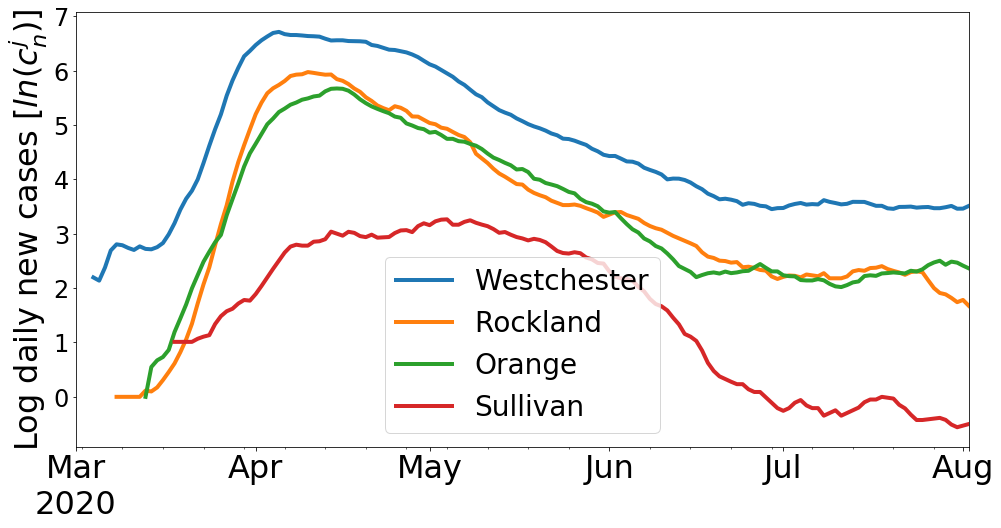

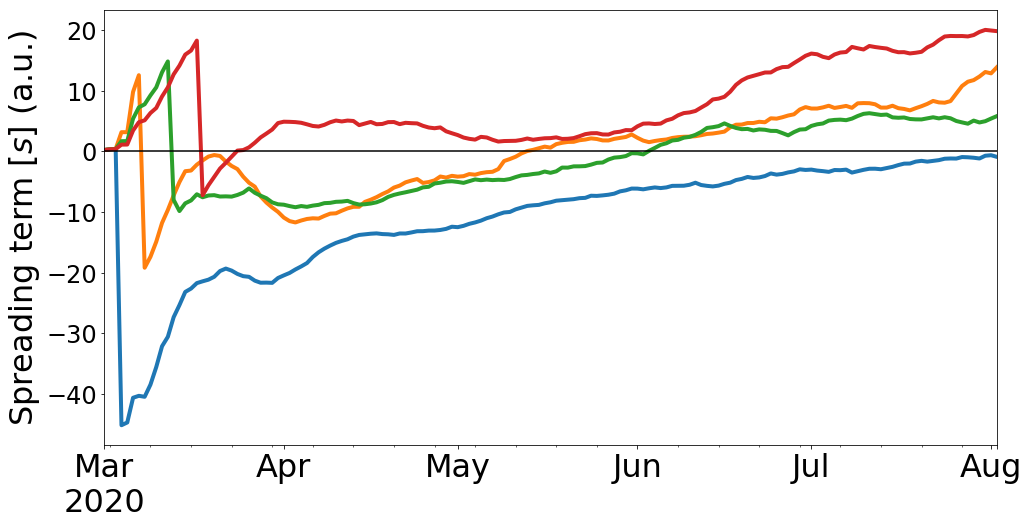

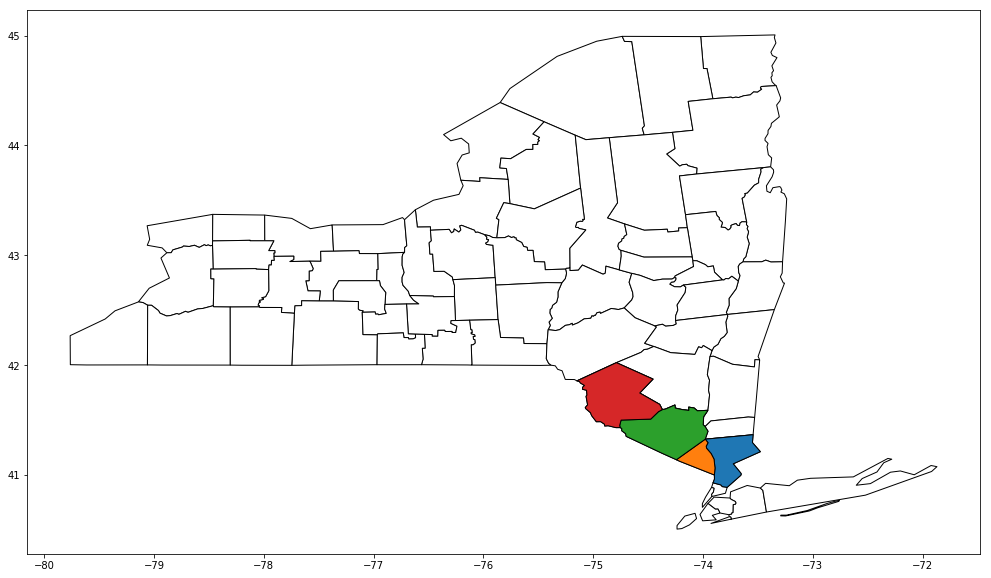

In [24]:
# Plot Spreading term (Diffusion)
plot_counties = [
    'New_York.Westchester',
    'New_York.Rockland',
    'New_York.Orange',
    'New_York.Sullivan',
]
df_plot_counties = pandas.DataFrame({'name' :plot_counties})
df_region_list = pandas.merge(df_plot_counties, df_region,on='name',how='left')

keys = df_region_list['pairs_id']
names = df_region_list['name'].values
names = [n.split('.')[-1] for n in names]

df_plot_logCases = df_LogCases[keys]
df_plot_logCases.plot(lw=4,figsize=(16,8))
plt.xlabel('', size=32)
plt.ylabel('Log daily new cases [$ln(c^j_n)$]', size=32)
td = timedelta(3)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.legend(names, fontsize=28)
plt.show()

df_plot_diffusion = df_joined['Diffusion'][keys]
fig, ax = plt.subplots(figsize=(16,8))
df_plot_diffusion.plot(ax=ax, lw=4, legend=None)
ax_colors = [c.get_color() for c in ax.get_lines()]
plt.xlabel('', size=32)
plt.ylabel('Spreading term [$s$] (a.u.)', size=32)
td = timedelta(3)
plt.axhline(color='k')
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.show()

df_plot = geopandas.GeoDataFrame(df_region_list, geometry='poly')
df_region_helper_NY = df_region_helper[df_region_helper['State']=='New_York']
fig, ax = plt.subplots(figsize=(20,10))
df_region_helper_NY.plot(ax=ax, facecolor="white", edgecolor="black", lw=1)
df_plot.plot(ax=ax, facecolor=ax_colors, edgecolor="black", lw=1)
plt.show()

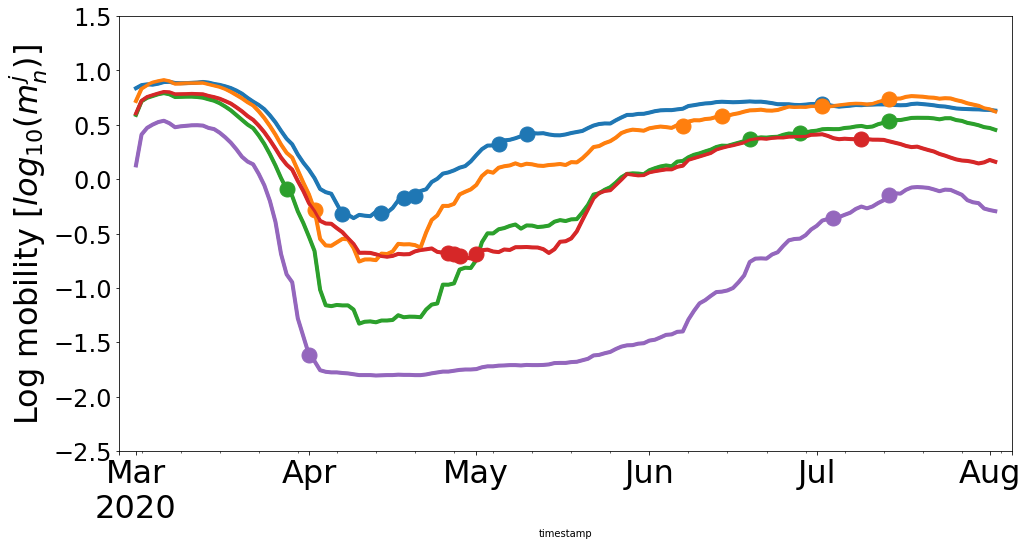

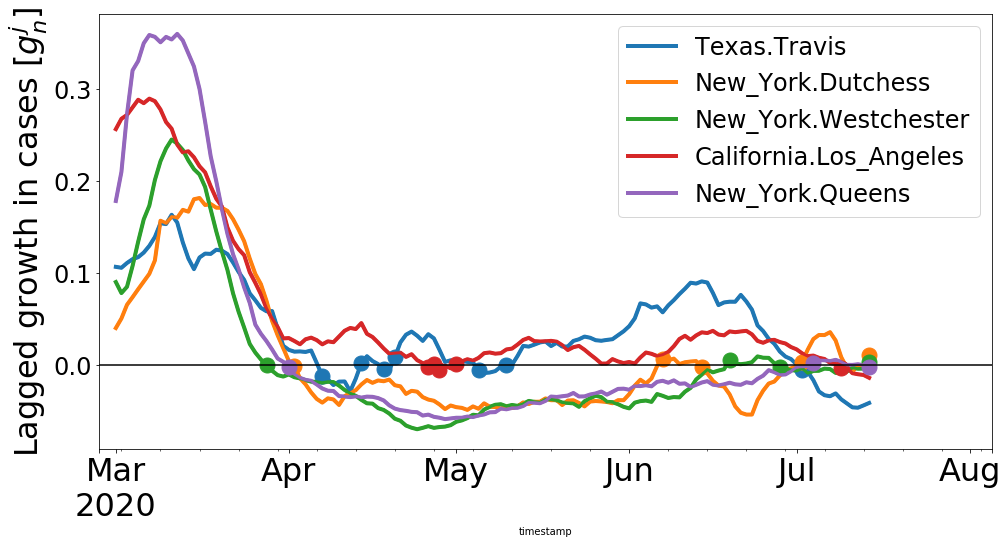

In [25]:
df_plot = df_lagged[lag_growthCases]
df_plot_filtered = df_lagged_filtered[lag_growthCases]

plot_counties = [
    'Texas.Travis',
    'New_York.Dutchess',
    'New_York.Westchester',
    'California.Los_Angeles',
    'New_York.Queens',
]
df_plot_counties = pandas.DataFrame({'name' :plot_counties})
df_region_list = pandas.merge(df_plot_counties, df_region,on='name',how='left')

keys = df_region_list['pairs_id']
names = df_region_list['name']


df_plot_growth = df_plot.swaplevel(axis=1)['subsequent_GrowthCases']
df_plot_growth = df_plot_growth[keys]

df_plot_filtered_growth = df_plot_filtered.swaplevel(axis=1)['subsequent_GrowthCases']
df_plot_filtered_growth = df_plot_filtered_growth[keys]


df_plot_logMobility = df_plot.swaplevel(axis=1)['LogMobility']
df_plot_logMobility = df_plot_logMobility[keys]

df_plot_filtered_logMobility = df_plot_filtered.swaplevel(axis=1)['LogMobility']
df_plot_filtered_logMobility = df_plot_filtered_logMobility[keys]

fig, ax = plt.subplots(figsize=(16,8))
df_plot_logMobility.plot(ax=ax, lw=4, legend=None)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
ax_colors = [c.get_color() for c in ax.get_lines()]
for pairs_id, c in zip(keys, ax_colors):
    df_plot_logMobility[pairs_id].plot(lw=3, c=c)
    df_plot_filtered_logMobility[pairs_id].plot(marker='o', markersize=15, ls='None', c=c)
plt.ylabel('Log mobility [$log_{10}(m^j_n)$]', size=32)
td = timedelta(3)
plt.xlim(xmin=df_plot.index[0]-td, xmax=df_plot.index[-1]+td)
plt.ylim(ymin=-2.5, ymax=1.5)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.show()

fig, ax = plt.subplots(figsize=(16,8))
df_plot_growth.plot(ax=ax, lw=4, legend=None)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
ax_colors = [c.get_color() for c in ax.get_lines()]
for pairs_id, c in zip(keys, ax_colors):
    df_plot_growth[pairs_id].plot(lw=3, c=c)
    df_plot_filtered_growth[pairs_id].plot(marker='o', markersize=15, ls='None', c=c)
plt.ylabel('Lagged growth in cases $[g^j_n]$', size=32)
plt.xlim(xmin=df_plot.index[0]-td, xmax=df_plot.index[-1]+td)
plt.legend(names.values, fontsize=24)
plt.axhline(color='k')
plt.show()

/home/ipython/software/python/python27/virtualenvs/pairs-python/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


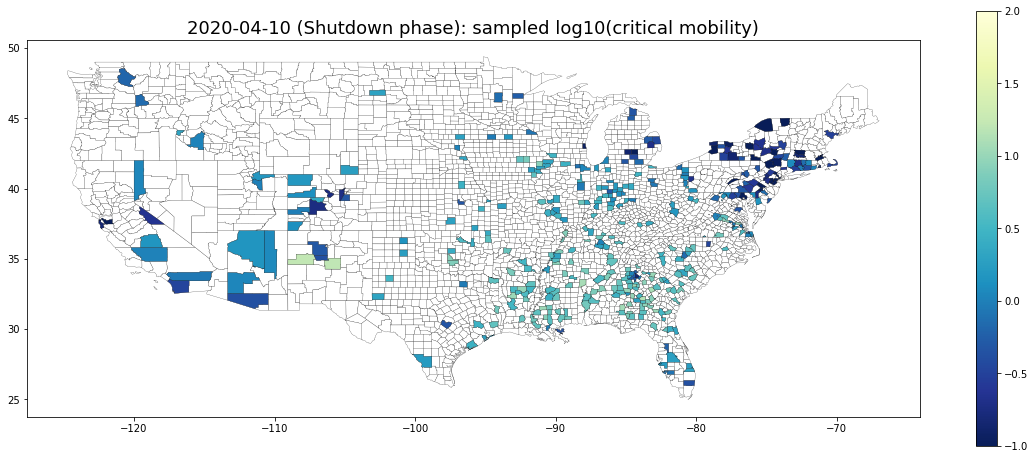

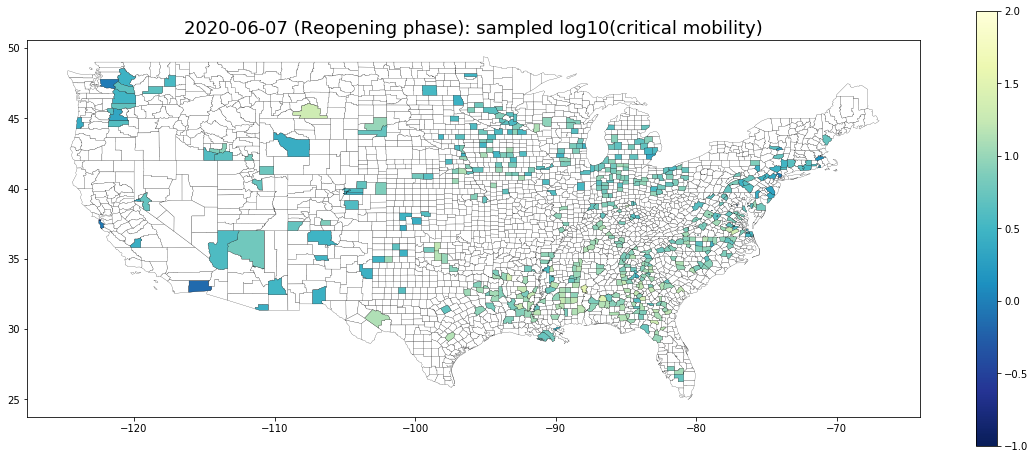

In [26]:
# Make an averaged (over the lag dimension) version of the sample data for plotting purposes
lag_list = numpy.arange(lag_growthCases-lag_growthCasesStd, lag_growthCases+lag_growthCasesStd+1)
numpy_data = numpy.nanmean([df_lagged_filtered[i].values for i in lag_list], axis=0)
df_lagged_filtered_averaged = pandas.DataFrame(data=numpy_data,
                                               columns=df_lagged_filtered[lag_growthCases].columns,
                                               index=df_lagged_filtered[lag_growthCases].index)

df_plot_LM = df_lagged_filtered_averaged.swaplevel(axis=1)['LogMobility']

dt1 = dt_shutdown

date = dt1.strftime('%Y-%m-%d')
df_plot = df_plot_LM.loc[dt1].dropna().reset_index()
df_plot = pandas.merge(df_plot, df_region_helper[['pairs_id', 'poly']], on='pairs_id')
df_plot = geopandas.GeoDataFrame(df_plot, geometry='poly')
fig, ax = plt.subplots(figsize=(20,8))
df_region_helper.plot(ax=ax, facecolor="white", edgecolor="black", lw=0.2)
df_plot.plot(ax=ax, column=dt1, legend=True, edgecolor="black", lw=0.2, cmap='YlGnBu_r', vmin=-1, vmax=2)
plt.title(date + ' (Shutdown phase): sampled log10(critical mobility)', size=18)
plt.show()

dt1 = dt_reopening

date = dt1.strftime('%Y-%m-%d')
df_plot = df_plot_LM.loc[dt1].dropna().reset_index()
df_plot = pandas.merge(df_plot, df_region_helper[['pairs_id', 'poly']], on='pairs_id')
df_plot = geopandas.GeoDataFrame(df_plot, geometry='poly')
fig, ax = plt.subplots(figsize=(20,8))
df_region_helper.plot(ax=ax, facecolor="white", edgecolor="black", lw=0.2)
df_plot.plot(ax=ax, column=dt1, legend=True, edgecolor="black", lw=0.2, cmap='YlGnBu_r', vmin=-1, vmax=2)
plt.title(date + ' (Reopening phase): sampled log10(critical mobility)', size=18) 
plt.show()

slope_scaled (growth factor)  0.00836062784129304
pct growth     1.9437553462688717


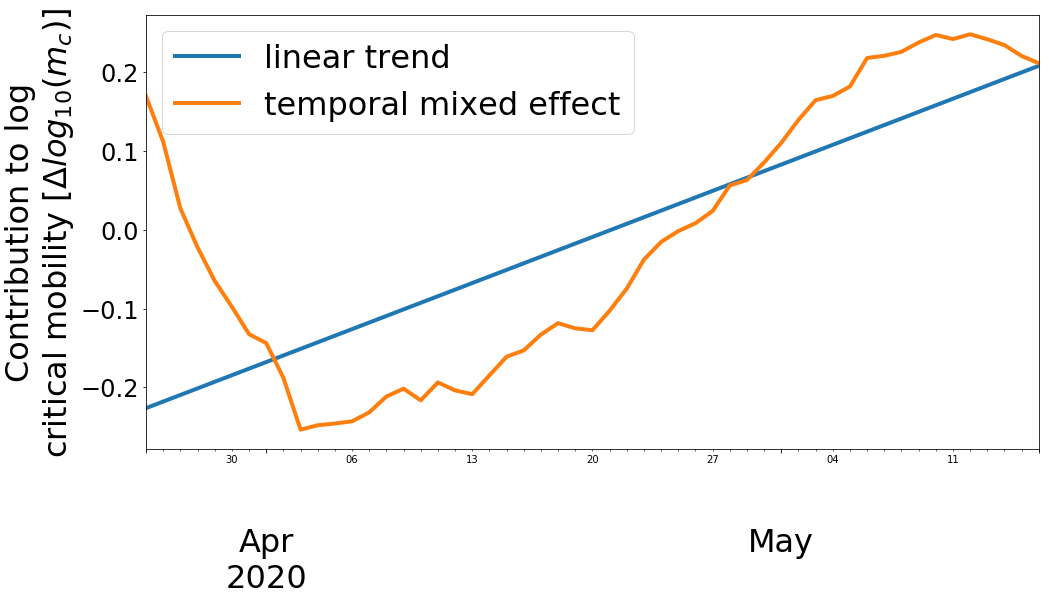

In [27]:
if 'day' in lmer1.fe_params:
    dt_day_start = datetime(2020,1,1, tzinfo=pytz.utc)
    
    df_plot = df_date_intercepts.copy()
    df_plot = df_plot.set_index('date')
    df_plot.index = [datetime.strptime(x, '%Y-%m-%d') for x in df_plot.index]
    df_plot['day'] = (df_plot.index - datetime(dt_day_start.year, dt_day_start.month, dt_day_start.day)).days
    xs = df_plot['day'].values
    
    # Fitting parameter
    slope_day = lmer1.fe_params['day'].values[0]
    
    # to reverse the standardscaler
    scale_day = scaler.scale_[scaling_columns.index('day')]
    mean_day = scaler.mean_[scaling_columns.index('day')]
    xs_scaled = (xs-mean_day)/scale_day
    
    slope_scaled = slope_day / scale_day
    print('slope_scaled (growth factor) ', slope_scaled)
    print('pct growth    ', 100*(10**slope_scaled-1))
    
    # Since we don't need the day column, just overwrite
    df_plot['day'] = slope_day * xs_scaled

    df_plot['temporal mixed effect'] = df_plot['day'] + df_plot['date Intercept']
    df_plot = df_plot.rename(columns={'day': 'linear trend'})
    
    df_plot[['linear trend', 'temporal mixed effect']].plot(lw=4, figsize=(16,8))
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=24)
    plt.xlabel('', size=32)
    plt.ylabel('Contribution to log\ncritical mobility $[\Delta log_{10}( m_c )]$', size=32)
    #plt.title('Critical Mobility Components: Temporal mixed effects', size=18)
    plt.legend(fontsize=32)
    plt.show()

/home/ipython/software/python/python27/virtualenvs/pairs-python/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ipython/software/python/python27/virtualenvs/pairs-python/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


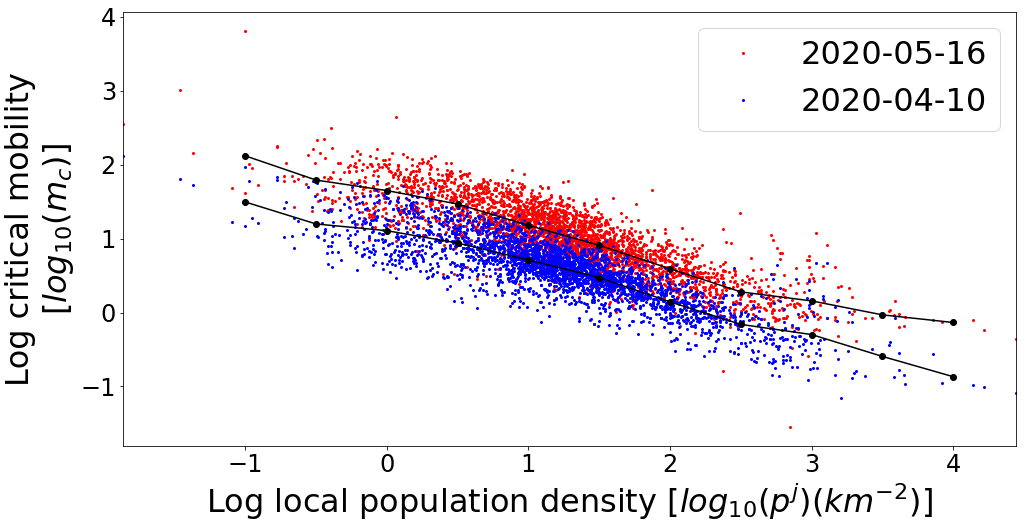

In [28]:
# Population density dependence of critical mobility
# Binning the fit
xmin=-1.
xmax=4.
dx = 0.5

dt1 = dt_shutdown
dt2 = dt_reopening
# In case the second timestamp does not exist yet chose the latest
dt2b = datetime(*datetime.strptime(last_date_with_intercept, '%Y-%m-%d').timetuple()[0:6], tzinfo=pytz.utc)
if dt2b<dt2:
    dt2=dt2b

df1 = df_preds[df_preds['timestamp']==dt1]
df2 = df_preds[df_preds['timestamp']==dt2]

# Binning the fit
xs = list(numpy.arange(xmin, xmax+dx, dx))
bins = list(numpy.arange(xmin-dx/2, xmax+3/2*dx, dx))
df1['bin'] = pandas.cut(df1['LogPopDensity'], bins)
df2['bin'] = pandas.cut(df2['LogPopDensity'], bins)

# Conditional means given the population by binning
df1_conditional_mean = df1.groupby('bin').mean()
df2_conditional_mean = df2.groupby('bin').mean()

# apply standard scaler
df1_conditional_mean[scaling_columns] = scaler.transform(df1_conditional_mean[scaling_columns])
df2_conditional_mean[scaling_columns] = scaler.transform(df2_conditional_mean[scaling_columns])

# Multipy with the fitting slope
fe_conditional_mean_1 = {}
fe_conditional_mean_2 = {}
for f in lmer1.fe_params.columns:
    if f not in ['(Intercept)', 'LogPopDensity', 'day']:
        fe_conditional_mean_1[f] = lmer1.fe_params[f]['Estimate'] * df1_conditional_mean[f]
        fe_conditional_mean_2[f] = lmer1.fe_params[f]['Estimate'] * df2_conditional_mean[f]
df1_fe_conditional_mean = pandas.DataFrame(fe_conditional_mean_1)
df2_fe_conditional_mean = pandas.DataFrame(fe_conditional_mean_2)
df1_fe_conditional_mean.sum(axis=1)


df1 = df1.set_index('LogPopDensity')
df2 = df2.set_index('LogPopDensity')

plt.figure(figsize=(16, 8))

df2['preds'].plot(marker='o', markersize=2, ls='None', c='red', label=dt2.date())
df1['preds'].plot(marker='o', markersize=2, ls='None', c='blue', label=dt1.date())

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.xlabel('Log local population density $[log_{10}(p^j) (km^{-2})]$', size=32)
plt.ylabel('Log critical mobility\n$[log_{10}(m_c)]$', size=32)

plt.legend(fontsize=32)

# Fitting parameter
overall_intercept = lmer1.fe_params['(Intercept)']['Estimate']
slope_day = lmer1.fe_params['day']['Estimate']
slope_LogPopDensity = lmer1.fe_params['LogPopDensity']['Estimate']

date1 = dt1.strftime('%Y-%m-%d')
date2 = dt2.strftime('%Y-%m-%d')

day1 = (dt1-datetime(2020,1,1, tzinfo=pytz.utc)).days
day2 = (dt2-datetime(2020,1,1, tzinfo=pytz.utc)).days

# Random intercept
df_date_intercepts = vars(lmer1)['re_params']['date'].reset_index(drop=True)
df_date_intercepts = df_date_intercepts.rename(columns={'(Intercept)': 'date Intercept'})

date1_intercept = df_date_intercepts[df_date_intercepts['date']==date1]['date Intercept'].values[0]
date2_intercept = df_date_intercepts[df_date_intercepts['date']==date2]['date Intercept'].values[0]

# to reverse the standardscaler
scale_day = scaler.scale_[scaling_columns.index('day')]
mean_day = scaler.mean_[scaling_columns.index('day')]
day1_scaled = (day1-mean_day)/scale_day
day1_intercept = day1_scaled * slope_day
day2_scaled = (day2-mean_day)/scale_day
day2_intercept = day2_scaled * slope_day

scale_LogPopDensity = scaler.scale_[scaling_columns.index('LogPopDensity')]
mean_LogPopDensity = scaler.mean_[scaling_columns.index('LogPopDensity')]
xs_scaled = (xs-mean_LogPopDensity)/scale_LogPopDensity

plt.plot(xs, overall_intercept + df1_fe_conditional_mean.sum(axis=1) + 
         date1_intercept + day1_intercept + slope_LogPopDensity * xs_scaled, c='black', marker='o')
plt.plot(xs, overall_intercept + df2_fe_conditional_mean.sum(axis=1) + 
         date2_intercept + day2_intercept + slope_LogPopDensity * xs_scaled, c='black', marker='o')

plt.show()

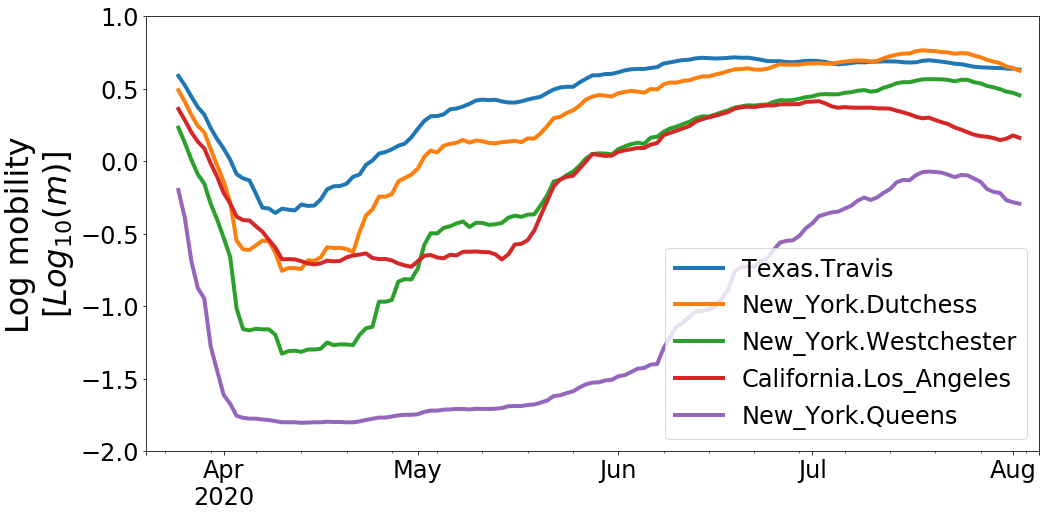

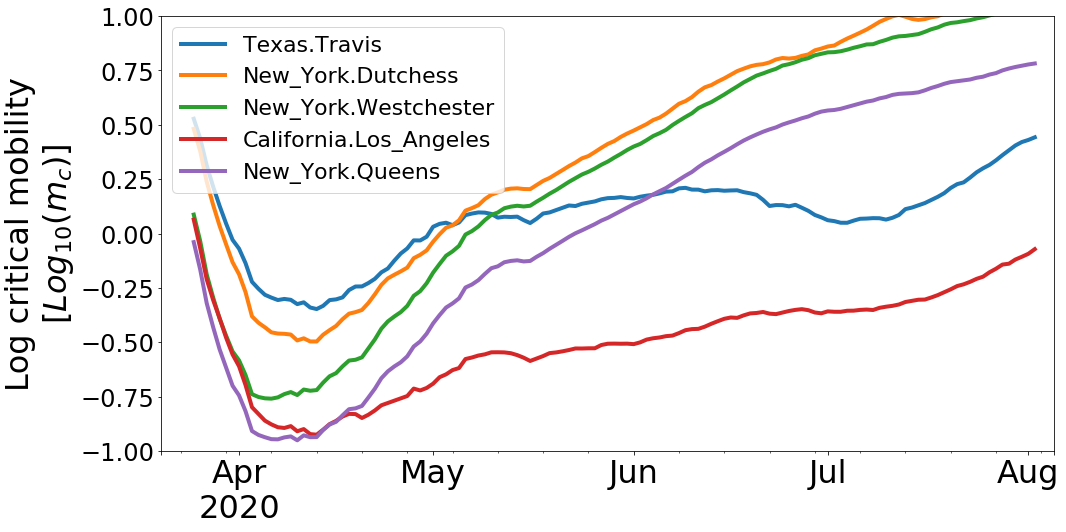

In [29]:
df1 = df_lagged_filtered[lag_growthCases].swaplevel(axis=1)['LogMobility']
df2 = df_preds[['pairs_id', 'timestamp', 'preds']].set_index(['timestamp', 'pairs_id']).unstack()['preds']
df3 = df_preds[['pairs_id', 'timestamp', 'LogMobility']].set_index(['timestamp', 'pairs_id']).unstack()['LogMobility']
df4 = df_preds[['pairs_id', 'timestamp', 'GrowthCases']].set_index(['timestamp', 'pairs_id']).unstack()['GrowthCases']

# Create the multiindex
df1.columns = pandas.MultiIndex.from_product([df1.columns, ['measured_logCM']])
df1.columns.names = ['pairs_id', None]
df2.columns = pandas.MultiIndex.from_product([df2.columns, ['modeled_logCM']])
df2.columns.names = ['pairs_id', None]
df3.columns = pandas.MultiIndex.from_product([df3.columns, ['LogMobility']])
df3.columns.names = ['pairs_id', None]
df4.columns = pandas.MultiIndex.from_product([df4.columns, ['GrowthCases']])
df4.columns.names = ['pairs_id', None]

df = df1.swaplevel(axis=1).join(df2.swaplevel(axis=1))
df = df.join(df3.swaplevel(axis=1))
df = df.join(df4.swaplevel(axis=1))
df = df.swaplevel(axis=1)
df.tail()

df_plot = df
df_plot_filtered = df

plot_counties = [
    'Texas.Travis',
    'New_York.Dutchess',
    'New_York.Westchester',
    'California.Los_Angeles',
    'New_York.Queens',
]
df_plot_counties = pandas.DataFrame({'name' :plot_counties})
df_region_list = pandas.merge(df_plot_counties, df_region,on='name',how='left')

keys = df_region_list['pairs_id']
names = df_region_list['name']


df_plot_model = df_plot.swaplevel(axis=1)['modeled_logCM']
df_plot_model = df_plot_model[keys]

df_plot_logMobility = df_plot.swaplevel(axis=1)['LogMobility']
df_plot_logMobility = df_plot_logMobility[keys]

plt.figure(figsize=(16,8))
for pairs_id in keys:
    df_plot_logMobility[pairs_id].plot(lw=4)
plt.xlabel('', size=32)
plt.ylabel('Log mobility\n$[Log_{10}(m)]$', size=32)
td = timedelta(3)
plt.xlim(xmin=datetime(2020,3,20), xmax=df_plot.index[-1]+td)
plt.ylim(ymin=-2, ymax=1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(names.values, fontsize=24)
plt.show()

plt.figure(figsize=(16,8))
for pairs_id in keys:
    df_plot_model[pairs_id].plot(lw=4)
plt.xlabel('', size=18)
plt.ylabel('Log critical mobility\n$[Log_{10}(m_c)]$', size=32)
td = timedelta(3)
plt.xlim(xmin=datetime(2020,3,20), xmax=df_plot.index[-1]+td)
plt.ylim(ymin=-1, ymax=1)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.legend(names.values, fontsize=22)
plt.show()


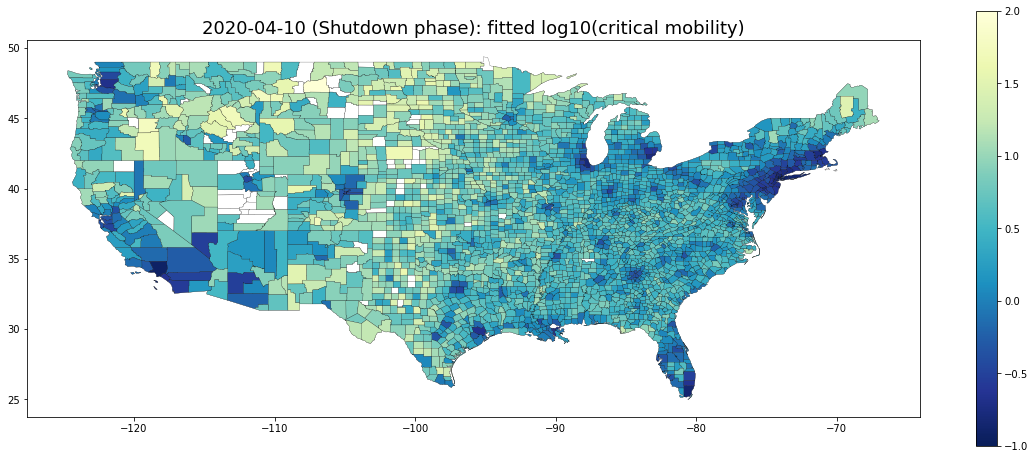

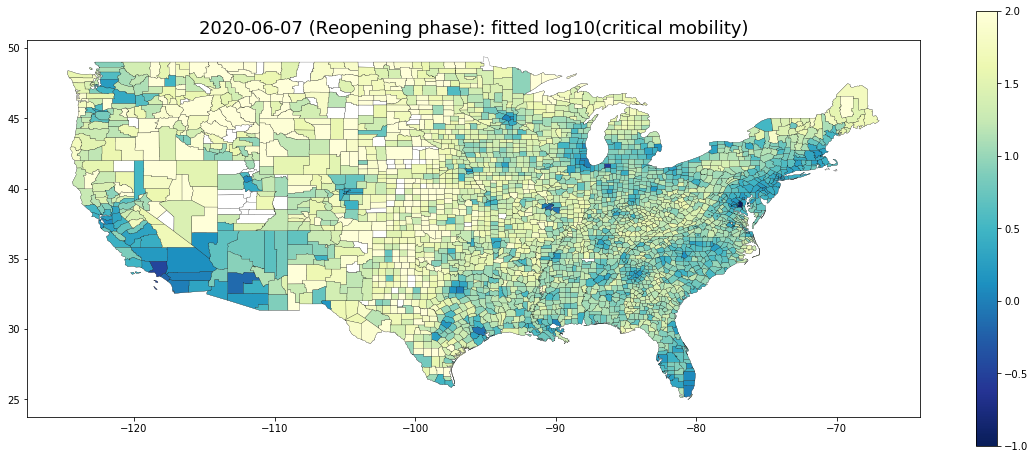

In [30]:
# Plot critical mobility maps

dt1 = dt_shutdown

date = dt1.strftime('%Y-%m-%d')
df_plot = df_preds[df_preds['date']==date][['pairs_id', 'preds']].dropna().reset_index()
df_plot = pandas.merge(df_plot, df_region_helper[['pairs_id', 'poly']], on='pairs_id')
df_plot = geopandas.GeoDataFrame(df_plot, geometry='poly')
fig, ax = plt.subplots(figsize=(20,8))
df_region_helper.plot(ax=ax, facecolor="white", edgecolor="black", lw=0.2)
df_plot.plot(ax=ax, column='preds', legend=True, edgecolor="black", lw=0.2, cmap='YlGnBu_r', vmin=-1, vmax=2)
plt.title(date + ' (Shutdown phase): fitted log10(critical mobility)', size=18)
plt.show()

dt1 = dt_reopening

date = dt1.strftime('%Y-%m-%d')
df_plot = df_preds[df_preds['date']==date][['pairs_id', 'preds']].dropna().reset_index()
df_plot = pandas.merge(df_plot, df_region_helper[['pairs_id', 'poly']], on='pairs_id')
df_plot = geopandas.GeoDataFrame(df_plot, geometry='poly')
fig, ax = plt.subplots(figsize=(20,8))
df_region_helper.plot(ax=ax, facecolor="white", edgecolor="black", lw=0.2)
df_plot.plot(ax=ax, column='preds', legend=True, edgecolor="black", lw=0.2, cmap='YlGnBu_r', vmin=-1, vmax=2)
plt.title(date + ' (Reopening phase): fitted log10(critical mobility)', size=18)
plt.show()

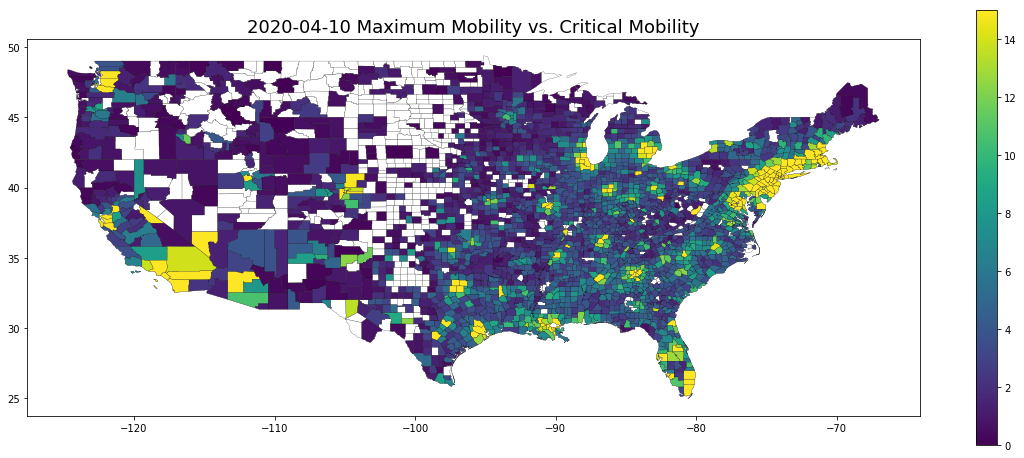

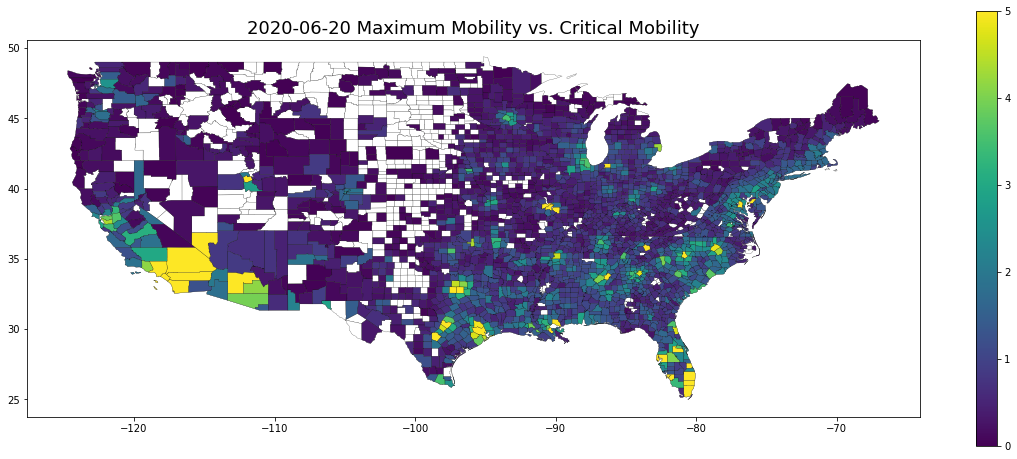

In [31]:
# Max Mobility vs. Critical Mobility Maps

date='2020-04-10'
df = df_preds[df_preds['date']==date][['pairs_id', 'preds', 'MaxMobility']]
df['ReducedMobility'] = (df['MaxMobility']/10**df['preds'])
df_plot = df.dropna().reset_index()
df_plot = pandas.merge(df_plot, df_region_helper[['pairs_id', 'poly']], on='pairs_id')
df_plot = geopandas.GeoDataFrame(df_plot, geometry='poly')
fig, ax = plt.subplots(figsize=(20,8))
df_region_helper.plot(ax=ax, facecolor="white", edgecolor="black", lw=0.2)
df_plot.plot(ax=ax, column='ReducedMobility', legend=True, edgecolor="black", cmap='viridis', vmin=0, vmax=15, lw=0.2)
plt.title(date + ' Maximum Mobility vs. Critical Mobility', size=18)
plt.show()

date='2020-06-20'
df = df_preds[df_preds['date']==date][['pairs_id', 'preds', 'MaxMobility']]
df['ReducedMobility'] = (df['MaxMobility']/10**df['preds'])
df_plot = df.dropna().reset_index()
df_plot = pandas.merge(df_plot, df_region_helper[['pairs_id', 'poly']], on='pairs_id')
df_plot = geopandas.GeoDataFrame(df_plot, geometry='poly')
fig, ax = plt.subplots(figsize=(20,8))
df_region_helper.plot(ax=ax, facecolor="white", edgecolor="black", lw=0.2)
df_plot.plot(ax=ax, column='ReducedMobility', legend=True, edgecolor="black", cmap='viridis', vmin=0, vmax=5, lw=0.2)
plt.title(date + ' Maximum Mobility vs. Critical Mobility', size=18)
plt.show()

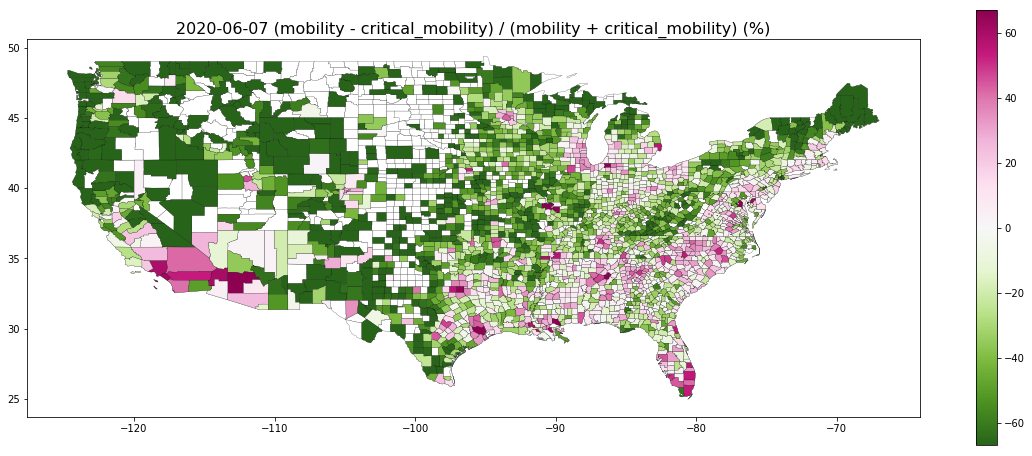

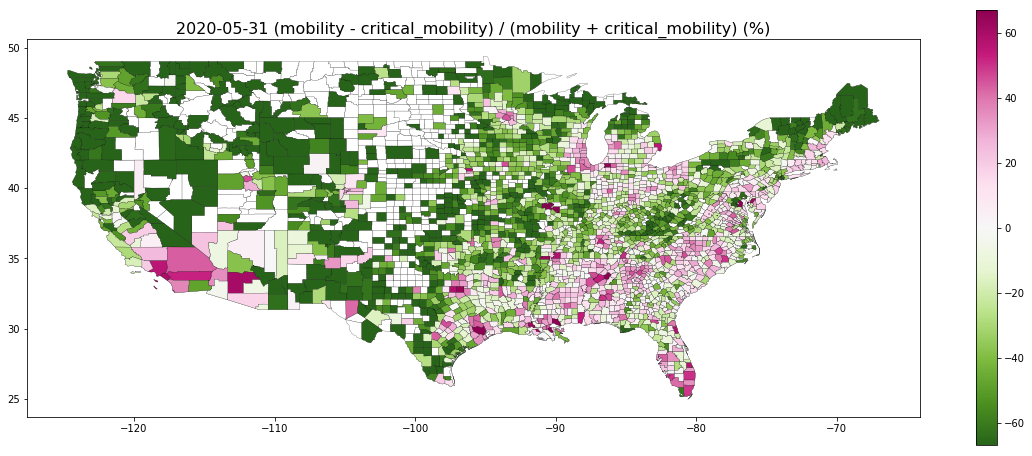

In [32]:
# Plot NDMI Map
dt1 = dt_reopening

date = dt1.strftime('%Y-%m-%d')
df_plot = df_preds[df_preds['date']==date][['pairs_id', 'preds']].dropna().reset_index()
df_plot['preds'] = 10** df_plot['preds']
df_tmp_mobility = df_Mobility.T[dt1].rename('Mobility').dropna().reset_index()
df_plot = pandas.merge(df_plot, df_tmp_mobility, on='pairs_id', how='left').dropna().reset_index()
df_plot = pandas.merge(df_plot, df_region_helper[['pairs_id', 'poly']], on='pairs_id')

df_plot['Value'] = 100 * (df_plot['Mobility'] - df_plot['preds']) / (df_plot['Mobility'] + df_plot['preds'])

df_plot = geopandas.GeoDataFrame(df_plot, geometry='poly')
fig, ax = plt.subplots(figsize=(20,8))
df_region_helper.plot(ax=ax, facecolor="white", edgecolor="black", lw=0.2)
df_plot.plot(ax=ax, column='Value', legend=True, edgecolor="black", lw=0.2,  cmap='PiYG_r', vmin=-67, vmax=67)
plt.title(date + ' (mobility - critical_mobility) / (mobility + critical_mobility) (%)', size=16)
plt.show()

try:
    dt1 = dt_cutoff_training_COVID

    date = dt1.strftime('%Y-%m-%d')
    df_plot = df_preds[df_preds['date']==date][['pairs_id', 'preds']].dropna().reset_index()
    df_plot['preds'] = 10** df_plot['preds']
    df_tmp_mobility = df_Mobility.T[dt1].rename('Mobility').dropna().reset_index()
    df_plot = pandas.merge(df_plot, df_tmp_mobility, on='pairs_id', how='left').dropna().reset_index()
    df_plot = pandas.merge(df_plot, df_region_helper[['pairs_id', 'poly']], on='pairs_id')

    df_plot['Value'] = 100 * (df_plot['Mobility'] - df_plot['preds']) / (df_plot['Mobility'] + df_plot['preds'])

    df_plot = geopandas.GeoDataFrame(df_plot, geometry='poly')
    fig, ax = plt.subplots(figsize=(20,8))
    df_region_helper.plot(ax=ax, facecolor="white", edgecolor="black", lw=0.2)
    df_plot.plot(ax=ax, column='Value', legend=True, edgecolor="black", lw=0.2,  cmap='PiYG_r', vmin=-67, vmax=67)
    plt.title(date + ' (mobility - critical_mobility) / (mobility + critical_mobility) (%)', size=16)
    plt.show()
except:
    pass 


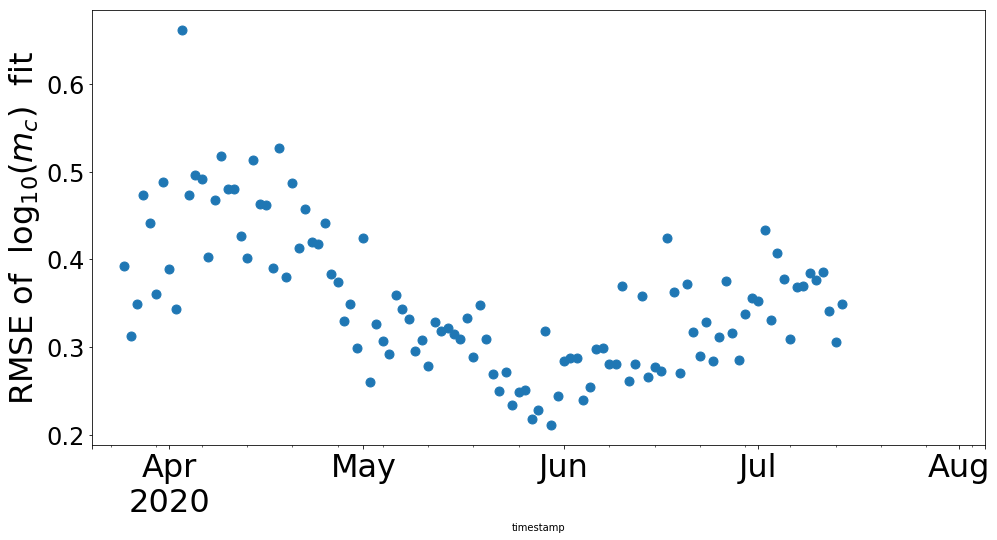

In [33]:
def grouped_rmse(row):
    return numpy.sqrt(numpy.nanmean((row[0] - row[1])**2))

df = df_preds.dropna(subset=['preds', 'LogCriticalMobility']).reset_index(drop=True)

df_mean = df_preds[['timestamp', 'preds']].groupby('timestamp').mean()

df_count = df_preds[['timestamp', 'preds']].groupby('timestamp').count().rename(columns={'preds':'n'})

df_rmse = df.groupby('timestamp').apply(lambda x: grouped_rmse(x[['preds', 'LogCriticalMobility']].values.T))
df_rmse.name = 'rmse'
df_rmse = pandas.DataFrame(df_rmse)

df_mean_rmse = df_mean.join(df_rmse).join(df_count)
df_mean_rmse = df_mean_rmse.dropna()

plt.figure(figsize=(16, 8))
df_mean_rmse['rmse'].plot(lw=0, marker='o', markersize=9, fontsize=18)
plt.ylabel(r'RMSE of  log$_{10}(m_c)$  fit', size=32)
td = timedelta(3)
plt.xlim(xmin=datetime(2020,3,20), xmax=dt_cutoff_latest+td)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.show()

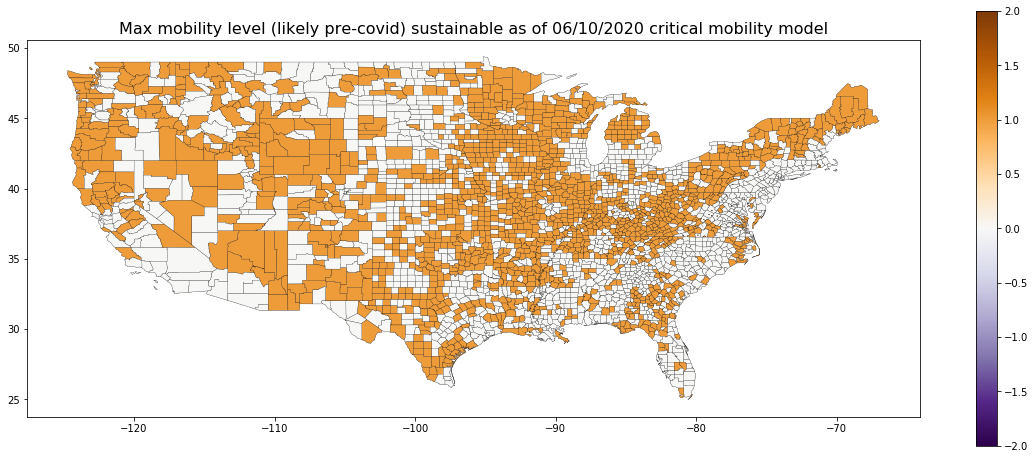

In [34]:
# Find counties that are already sustainable
dt1 = datetime(2020,6,10, tzinfo=pytz.utc)

# Instead of pre-COVID mobility get the maximum mobililty up to the analysis date
s_logMobilityMax = numpy.log10(df_joined['MaxMobility']).iloc[0]
s_logMobilityMax.name = 'logMobilityMax'

df = pandas.merge(df_preds, s_logMobilityMax.reset_index(), on='pairs_id', how='left')

df_plot = df[df['timestamp']==dt1].reset_index(drop=True)
df_plot['diff'] = (df_plot['logMobilityMax'] - df_plot['preds']) < 0
df_plot = pandas.merge(df_plot, df_region_helper[['pairs_id', 'poly']], on='pairs_id')

df_plot = geopandas.GeoDataFrame(df_plot, geometry='poly')
fig, ax = plt.subplots(figsize=(20,8))
df_region_helper.plot(ax=ax, facecolor="white", edgecolor="black", lw=0.2)
df_plot.plot(ax=ax, column='diff', legend=True, edgecolor="black", lw=0.2, cmap='PuOr_r', vmin=-2, vmax=2)
plt.title('Max mobility level (likely pre-covid) sustainable as of ' + dt1.strftime("%m/%d/%Y") + ' critical mobility model', size=16)
plt.show()

In [35]:
# Predicitve power analysis

MIN_CASES = 10
MIN_CASES_CAPITA = 0
lag_analysis_start = 14  # Dont use the first couple of days for testing since mobility has no effect yet
lag_analysis_end = 42

# Date of testing (NDMI is used from this date)
dt_analysis_testing = dt_cutoff_training_COVID

dt_analysis_covid_start = dt_analysis_testing + timedelta(lag_analysis_start)
dt_analysis_covid_end = dt_analysis_testing + timedelta(lag_analysis_end)
print('Mobility data considered from', dt_analysis_testing, ' to ', dt_analysis_testing)
print('COVID-19 data considered from', dt_analysis_covid_start, ' to ', dt_analysis_covid_end)
print('lag_analysis_start', lag_analysis_start)
print('lag_analysis_end', lag_analysis_end)

df = df_NDMI.loc[dt_analysis_testing.strftime('%Y-%m-%d')].unstack().T
print('Original number counties ', len(df))
df = df[df['Cases']>=MIN_CASES]
df = df[df['CasesCapita']>=MIN_CASES_CAPITA]
print('Filtered number counties ',len(df))

filtered_pairs_ids = sorted(list(df.index.values))
df_NDMI_filtered=df_NDMI.swaplevel(axis=1)[filtered_pairs_ids].swaplevel(axis=1)

df_analysis_cases = df_LogCases.apply(lambda x: numpy.exp(x))

df_analysis_cases.index = [x.strftime('%Y-%m-%d') for x in df_analysis_cases.index]
df_analysis_cases.index.name = 'date'

# n day changes in cases
df_analysis_cases_shift_start = df_analysis_cases.shift(periods=-lag_analysis_start)
df_analysis_cases_shift_end = df_analysis_cases.shift(periods=-lag_analysis_end)

# Growth Rate
df_day_n_growth = numpy.log(df_analysis_cases_shift_end) - numpy.log(df_analysis_cases_shift_start)

Mobility data considered from 2020-05-31 00:00:00+00:00  to  2020-05-31 00:00:00+00:00
COVID-19 data considered from 2020-06-14 00:00:00+00:00  to  2020-07-12 00:00:00+00:00
lag_analysis_start 14
lag_analysis_end 42
Original number counties  3136
Filtered number counties  322


Number days averaged      28
Minimum number of new cases per 100 capita  0
Minimum number of new cases per county      10
Cutoff Date               2020-05-31 00:00:00+00:00
Cutoff NDMI               20
Cutoff COVID growth       0
Filtered number counties  312


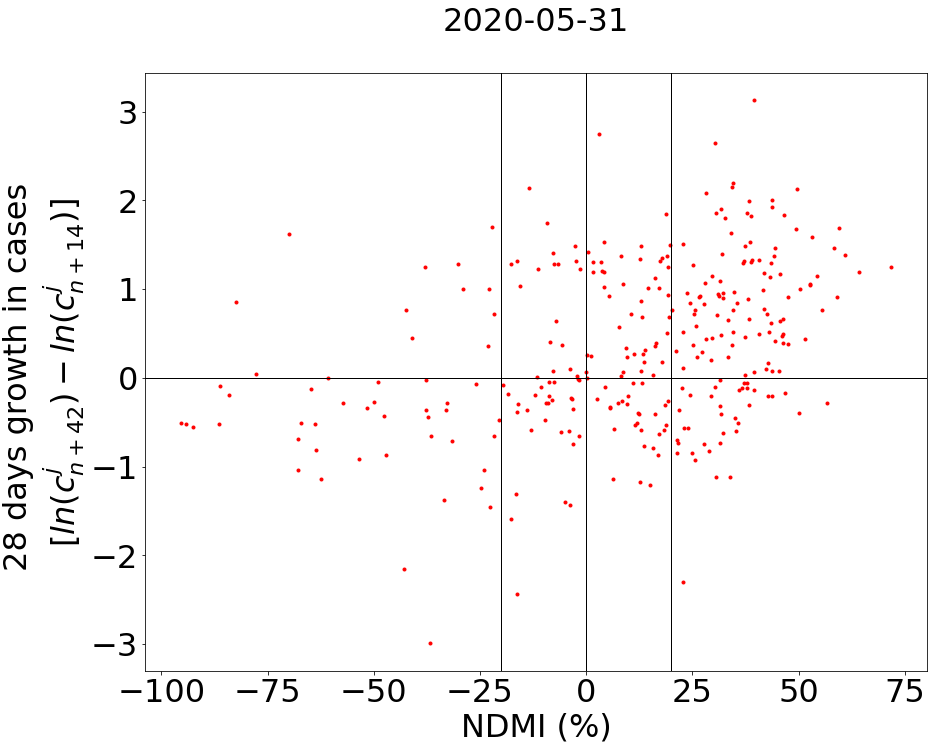

Confusion Matrix
[[103.  37.]
 [ 12.  37.]]
Total population  189.0
Accuracy          0.740740740741
F1 Score          0.807843137255


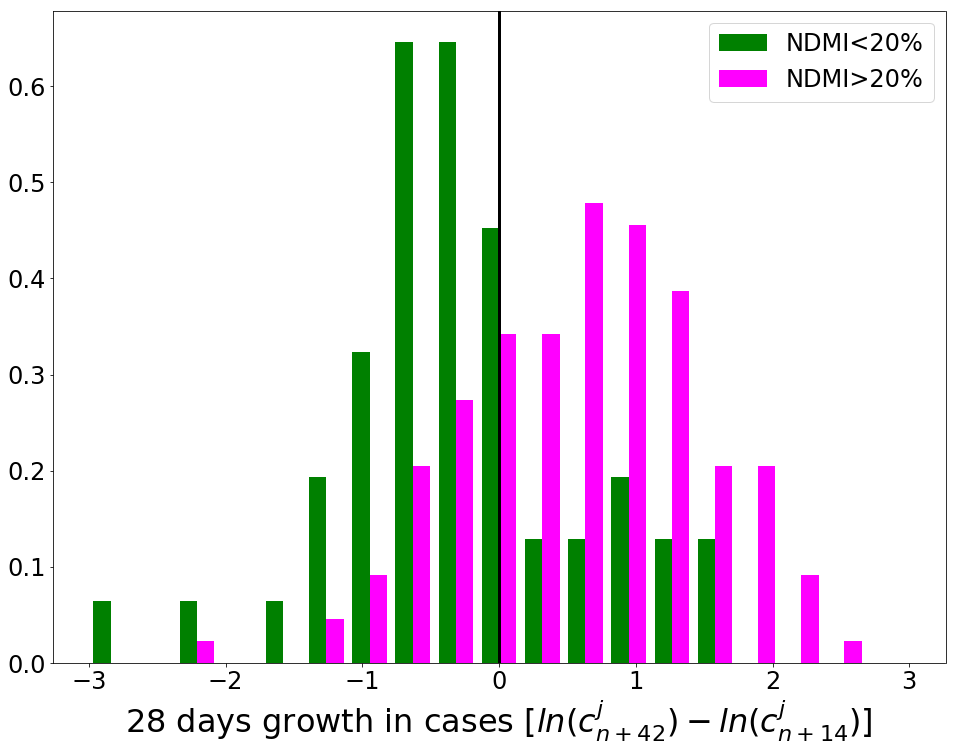

In [36]:
# COUNTY LEVEL TESTING

# Cutoff for NDMI
c=20
# Cutoff for growth in cases
k=0

print('Number days averaged     ', lag_analysis_end-lag_analysis_start)
print('Minimum number of new cases per 100 capita ', MIN_CASES_CAPITA)
print('Minimum number of new cases per county     ', MIN_CASES)
print('Cutoff Date              ', dt_analysis_testing)
print('Cutoff NDMI              ', c)
print('Cutoff COVID growth      ', k)

label_string = '$[ln(c^j_{n+42}) - ln(c^j_{n+14})]$'

# Create the multiindex
df_lag_analysis = df_day_n_growth.copy()
df_lag_analysis.columns = pandas.MultiIndex.from_product([df_lag_analysis.columns, ['SubsequentGrowthCases']])
df_lag_analysis.columns.names = ['pairs_id', None]
df_lag_analysis = df_lag_analysis.swaplevel(axis=1)


df_NDMI_analysis = df_NDMI_filtered[['NDMI']]

df_NDMI_analysis = pandas.merge(df_NDMI_analysis, df_lag_analysis, left_index=True, right_index=True)
df_NDMI_analysis = df_NDMI_analysis.swaplevel(axis=1)

df_analysis_testing = df_NDMI_analysis.loc[dt_analysis_testing.strftime('%Y-%m-%d')].unstack()
df_analysis_testing = df_analysis_testing.dropna(subset=['NDMI', 'SubsequentGrowthCases'])
print('Filtered number counties ',len(df_analysis_testing))

plt.figure(figsize=(14,11))
plt.scatter(df_analysis_testing['NDMI'], df_analysis_testing['SubsequentGrowthCases'], s=9, c='red')
# Plot some bands where we think we are confident
plt.axvline(c, color='k', lw=1)
plt.axvline(-c, color='k', lw=1)
plt.axhline(k, color='k', lw=1)
plt.axhline(-k, color='k', lw=1)

#plt.ylim(ymin=-.2, ymax=.2)
plt.xlabel('NDMI (%)', size=32)
plt.ylabel(str(lag_analysis_end-lag_analysis_start) + ' days growth in cases \n' + label_string, size=32)
plt.axhline(color='k', lw=1)
plt.axvline(color='k', lw=1)
plt.title(str(dt_analysis_testing.date()) + '\n', size=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.show()

# True positives
df_tp = df_analysis_testing[(df_analysis_testing['NDMI']>c) & 
                            (df_analysis_testing['SubsequentGrowthCases']>k)]
tp = float(len(df_tp))

# True negatives
df_tn = df_analysis_testing[(df_analysis_testing['NDMI']<-c) & 
                            (df_analysis_testing['SubsequentGrowthCases']<-k)]
tn = float(len(df_tn))

# False positives
df_fp = df_analysis_testing[(df_analysis_testing['NDMI']>c) & 
                            (df_analysis_testing['SubsequentGrowthCases']<-k)]
fp = float(len(df_fp))

# False negatives
df_fn = df_analysis_testing[(df_analysis_testing['NDMI']<-c) & 
                            (df_analysis_testing['SubsequentGrowthCases']>k)]
fn = float(len(df_fn))

conf = numpy.array(((tp,fp), (fn,tn)))
print('Confusion Matrix')
print(conf)

# Accuracy
acc = (tp+tn)/(tp+tn+fp+fn)
# F1 score
f1 = 2*tp/(2*tp+fp+fn)

print('Total population ', tp+tn+fp+fn)
print('Accuracy         ', acc)
print('F1 Score         ', f1)

df_analysis_testing['NDMI classes'] = 0
df_analysis_testing.loc[df_analysis_testing['NDMI']>c, 'NDMI classes'] = 1
df_analysis_testing.loc[df_analysis_testing['NDMI']<-c, 'NDMI classes'] = -1
df_analysis_testing['subsequent growth classes'] = 0
df_analysis_testing.loc[df_analysis_testing['SubsequentGrowthCases']>k, 'subsequent growth classes'] = 1
df_analysis_testing.loc[df_analysis_testing['SubsequentGrowthCases']<-k, 'subsequent growth classes'] = -1

df = df_analysis_testing[['NDMI classes', 'SubsequentGrowthCases']]

x = df[df['NDMI classes']==-1]['SubsequentGrowthCases'].values
y = df[df['NDMI classes']==0]['SubsequentGrowthCases'].values
z = df[df['NDMI classes']==1]['SubsequentGrowthCases'].values
bins = numpy.linspace(-3,3,20)

plt.figure(figsize=(16, 12))
plt.hist([x, z], bins, density=True, color=['green','magenta'],
         label=['NDMI<' + str(c) + '%', 'NDMI>' + str(c) + '%'])
plt.legend(loc='upper right', fontsize=24)
plt.xlabel(str(lag_analysis_end-lag_analysis_start) + ' days growth in cases ' + label_string, size=32)
plt.axvline(color='k', lw=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()